In [80]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    py_file_location = "/content/drive/MyDrive/Tesis/Git/RedVolcanica"
    %cd "{py_file_location}" 
    IN_COLAB = True
except:
    IN_COLAB = False
print(IN_COLAB)  

False


In [81]:
import importlib

import RedFunciones.visualizacion as visualizacion
import RedFunciones.Generador as Generador
import RedFunciones.Discriminador as Discriminador
import RedFunciones.auxiliares as auxiliares
import RedFunciones.DataloaderVol as DataloaderVol
import RedFunciones.Checkpoint as Checkpoint

importlib.reload(auxiliares)
importlib.reload(visualizacion)
importlib.reload(Generador)
importlib.reload(Discriminador)
importlib.reload(DataloaderVol)
importlib.reload(Checkpoint)

import Auxiliares.BinaryAccuracy as bin_acc

In [82]:
import torch
from torch import nn
import torchaudio

from tqdm.auto import tqdm # Progress bar

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST #noned

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0) # Set for our testing purposes, please do not change!

import os
cwd = os.getcwd()
print(cwd)

cuda0 = torch.device('cuda:2')
cpu = 'cpu'
device = torch.device(cuda0 if torch.cuda.is_available() else cpu)

/home/fgrijalva/RedVolcanica/RedVolcanica


criterion: the loss function

n_epochs: the number of times you iterate through the entire 
dataset when training

z_dim: the dimension of the noise vector

display_step: how often to display/visualize the images

batch_size: the number of images per forward/backward pass

lr: the learning rate

device: the device type

In [83]:
h5_filename = cwd + '/baseh5/baseSR10.h5'
nombre = 'master'
nombre_carga = 'master-2022-04-04.pt'

mnist_shape = (1, 129, 33) #tamaño imagen
n_classes = 2 # numkero etiquetas
z_dim = 64

n_epochs = 25
display_step = 50
batch_size = 16

lrg = 0.00001
beta_1_g = 0.5
beta_2_g = 0.999
c_lambda_g = 10
repeats_g = 1

lrd = 0.0001
beta_1_d = 0.5
beta_2_d = 0.999
crit_repeats = 5
c_lambda = 20

mean = 0
std = 1

guardar = False
cargar = False
save_steep = 1

epoch_temp = -1
gen_loss_temp = torch.empty([])
disc_loss_temp = torch.empty([]) 

In [84]:
mean_p = True

regularizaM = False
reg_lambda = 0.001

In [85]:
if mean_p:
    myDataA = DataloaderVol.VolcanoDatasetH5(h5_filename)
    dataloaderA = DataLoader(
        myDataA,
        batch_size=batch_size,
        shuffle=True)

    def get_mean_and_std(dataloader):
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0,2,3])
            channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
            num_batches += 1    
        mean = channels_sum / num_batches
        # std = sqrt(E[X^2] - (E[X])^2)
        std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
        return mean.item(), std.item()

    mean, std = get_mean_and_std(dataloaderA)
    print(mean)
    print(std)

0.0033407611568537945
0.008867404784656259


In [86]:
#cargar datos
if mean_p:
    transform = transforms.Compose([
        #transforms.ToTensor(),
        transforms.Normalize((mean,), (std,)),
        #torchaudio.transforms.MelScale(sample_rate=50, n_stft=129)
    ])    
else:
    transform = transforms.Compose([
        #transforms.ToTensor(),
        #transforms.Normalize((mean,), (std,)),
        #torchaudio.transforms.MelScale(sample_rate=50, n_stft=129)
    ])    
myData = DataloaderVol.VolcanoDatasetH5(h5_filename, transform)

dataloader = DataLoader(
    myData,
    batch_size=batch_size,
    shuffle=True)

#a, b = next(iter(dataloader))
#print(a)

In [87]:
generator_input_dim, discriminator_im_chan = auxiliares.get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generador.Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lrg, betas=(beta_1_g, beta_2_g))
disc = Discriminador.Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lrd, betas=(beta_1_d, beta_2_d))
gen = gen.apply(auxiliares.weights_init)
disc = disc.apply(auxiliares.weights_init)

gen.train()
disc.train()
        
metric = bin_acc.BinaryAccuracy()

In [88]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        inputs=mixed_images,
        outputs=mixed_scores,
        #### END CODE HERE ####
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm - 1)**2)
    #### END CODE HERE ####
    return penalty

# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    #### START CODE HERE ####
    gen_loss = -1. * torch.mean(crit_fake_pred)
    #### END CODE HERE ####
    return gen_loss

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    #### START CODE HERE ####
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    #### END CODE HERE ####
    return crit_loss

In [89]:
if cargar:
    compelto = Checkpoint.DIRECTORY + nombre_carga
    checkpoint = torch.load(compelto)
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])
    gen_opt.load_state_dict(checkpoint['gen_opt'])
    disc_opt.load_state_dict(checkpoint['disc_opt'])
    epoch_temp = checkpoint['epoch']
    gen_loss_temp = checkpoint['gen_loss']
    disc_loss_temp = checkpoint['dis_loss']
    print('Modelo cargado')
    print('epoch: ' + str(epoch_temp))

Epoch: 0


  0%|          | 0/385 [00:00<?, ?it/s]

Red Funcionando
Step 50: Generator loss: 1.0886254205554724, discriminator loss: 0.0
Espectrogramas Generados


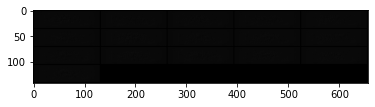

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


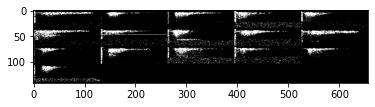

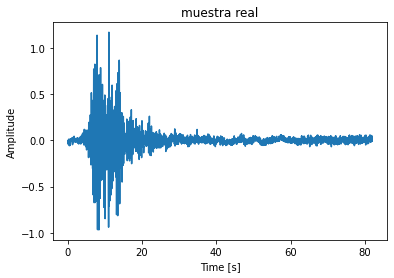

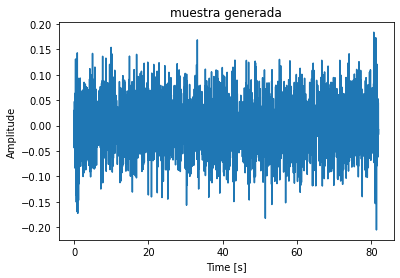

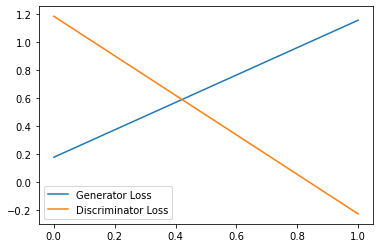

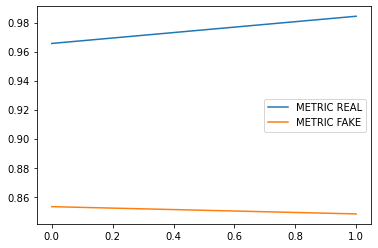

Step 100: Generator loss: 4.611314831972122, discriminator loss: 0.0
Espectrogramas Generados


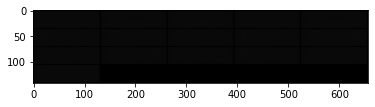

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


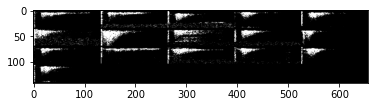

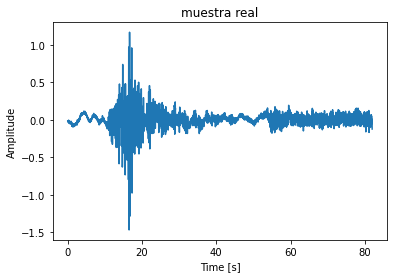

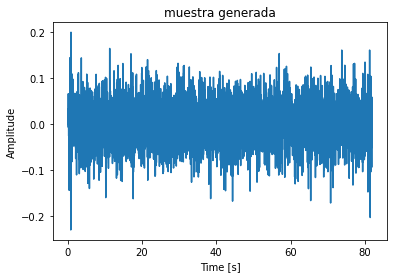

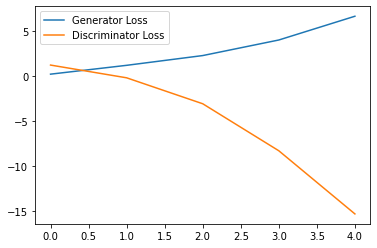

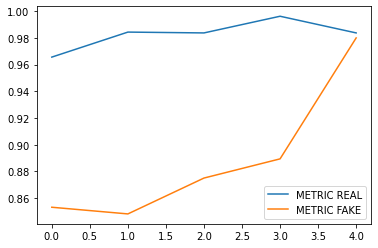

Step 150: Generator loss: 5.709379770755768, discriminator loss: 0.0
Espectrogramas Generados


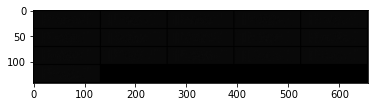

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


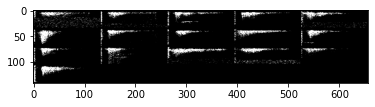

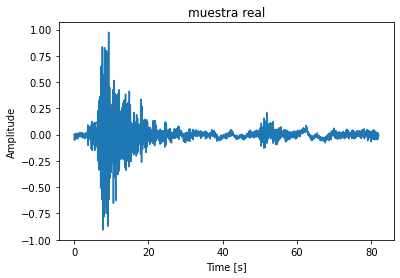

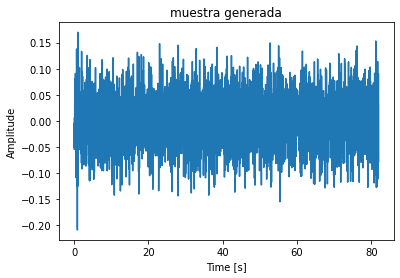

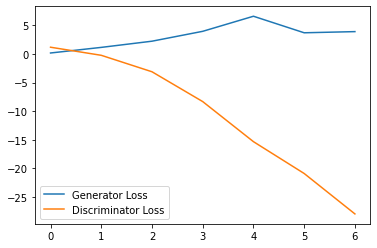

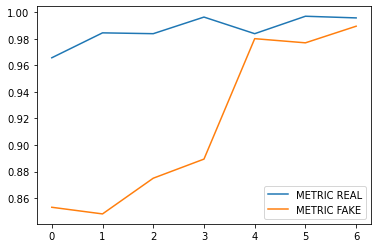

Step 200: Generator loss: 19.1069895029068, discriminator loss: 0.0
Espectrogramas Generados


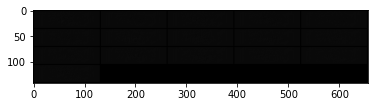

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


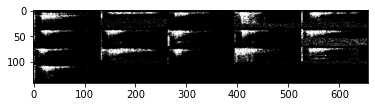

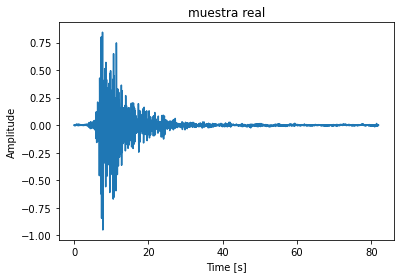

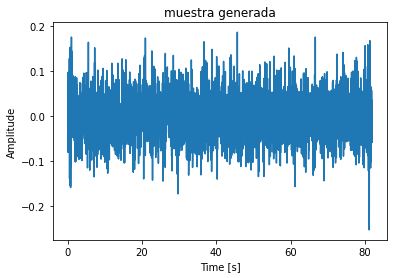

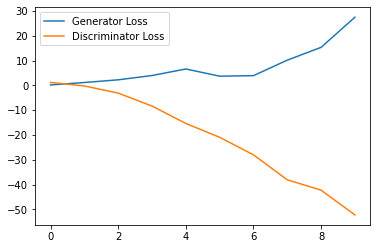

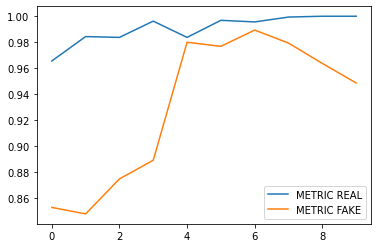

Step 250: Generator loss: 34.3319969367981, discriminator loss: 0.0
Espectrogramas Generados


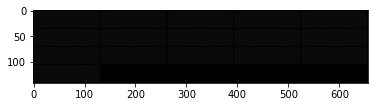

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


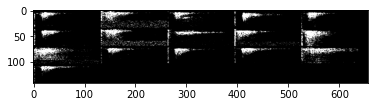

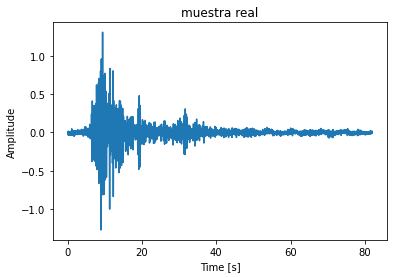

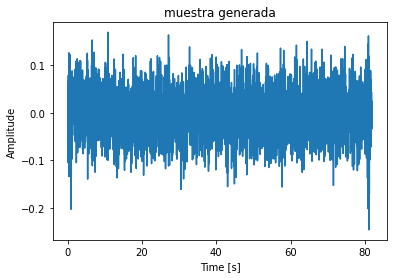

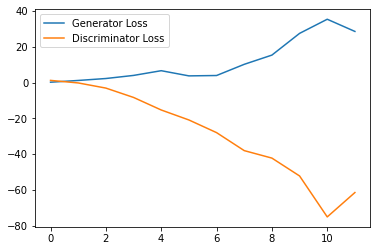

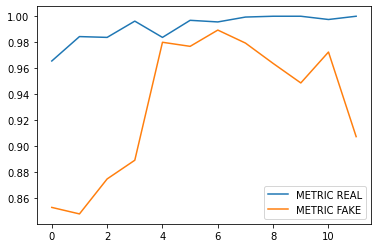

Step 300: Generator loss: 94.5710663318634, discriminator loss: 0.0
Espectrogramas Generados


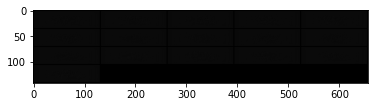

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


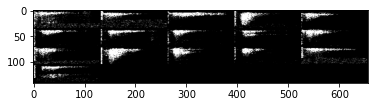

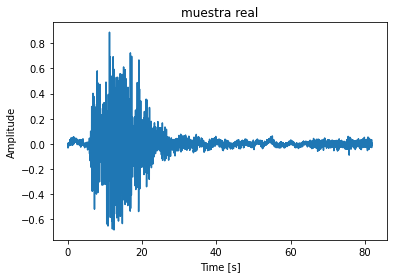

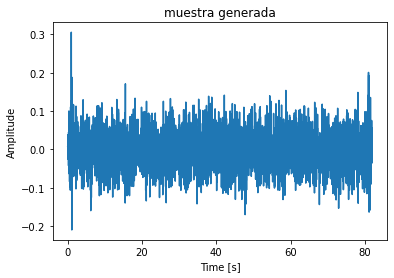

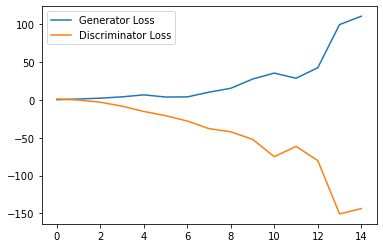

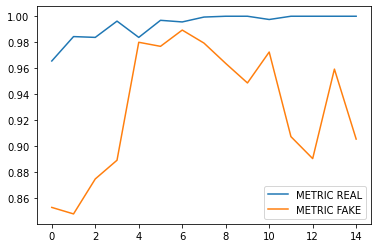

Step 350: Generator loss: 164.44429618835449, discriminator loss: 0.0
Espectrogramas Generados


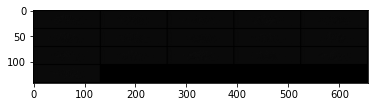

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


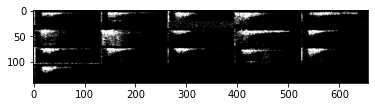

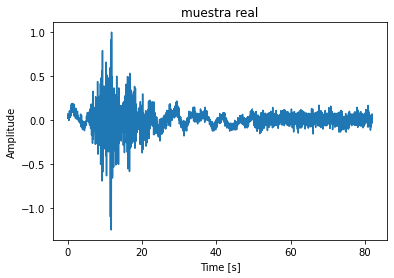

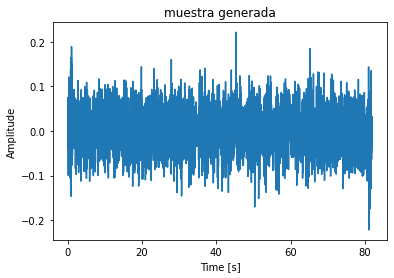

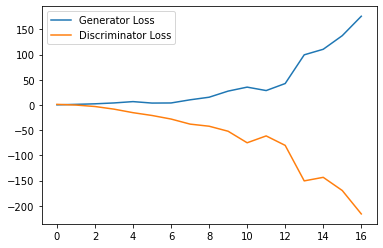

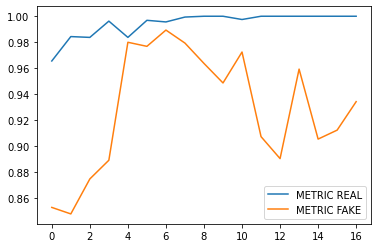

Epoch: 1


  0%|          | 0/385 [00:00<?, ?it/s]

Step 400: Generator loss: 222.1665023803711, discriminator loss: 0.0
Espectrogramas Generados


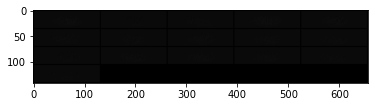

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


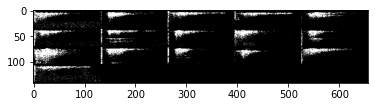

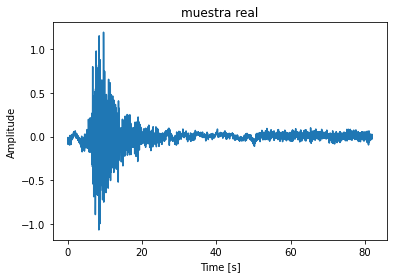

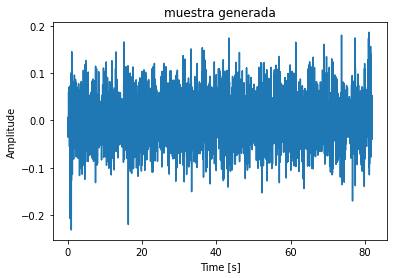

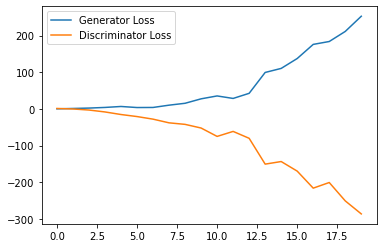

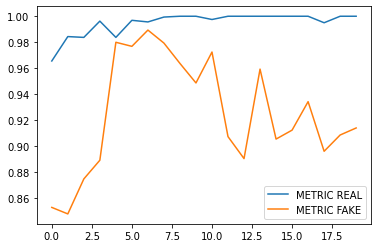

Step 450: Generator loss: 308.31046249389647, discriminator loss: 0.0
Espectrogramas Generados


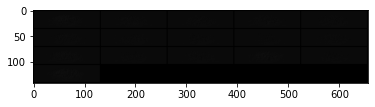

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


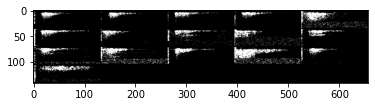

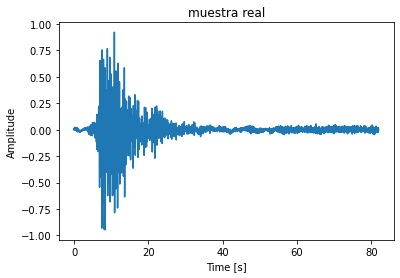

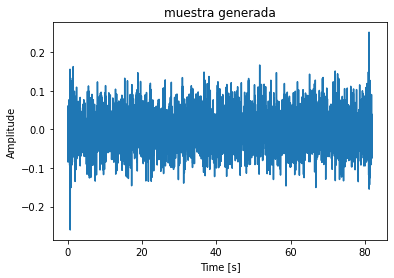

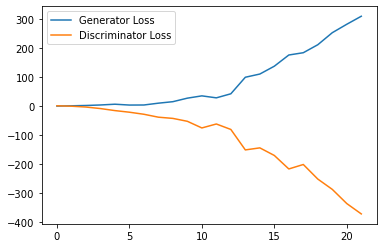

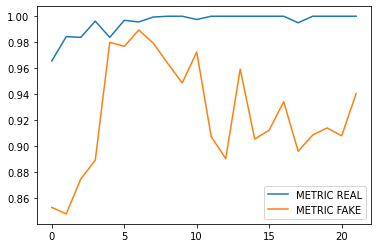

Step 500: Generator loss: 396.9486370849609, discriminator loss: 0.0
Espectrogramas Generados


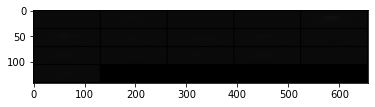

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


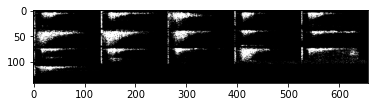

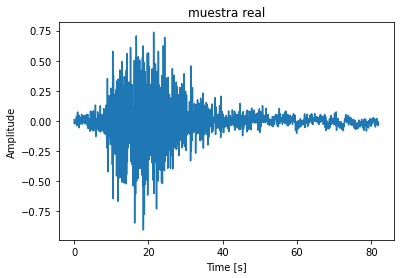

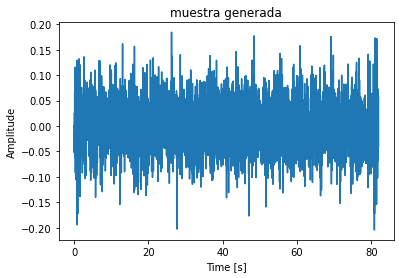

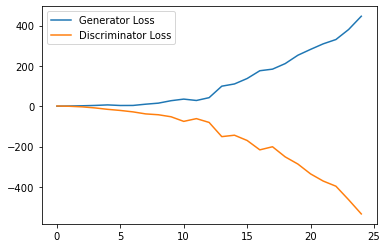

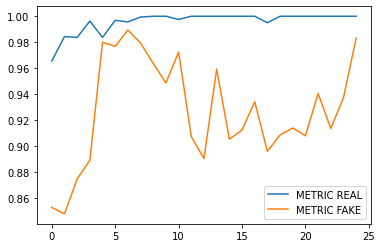

Step 550: Generator loss: 494.9395446777344, discriminator loss: 0.0
Espectrogramas Generados


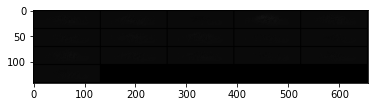

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


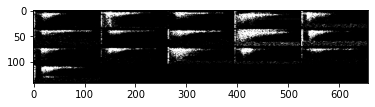

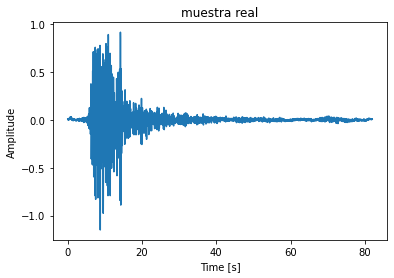

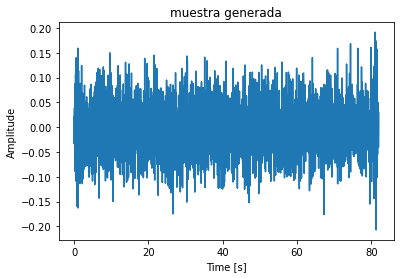

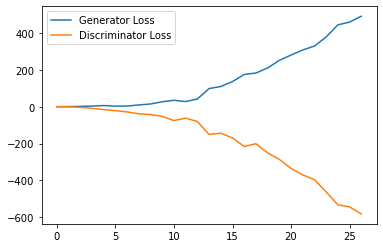

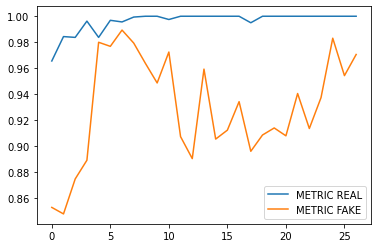

Step 600: Generator loss: 588.73337890625, discriminator loss: 0.0
Espectrogramas Generados


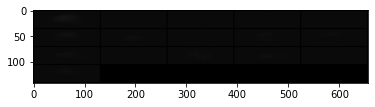

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


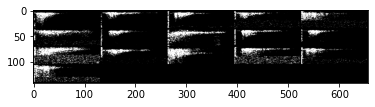

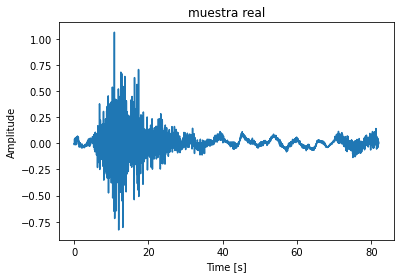

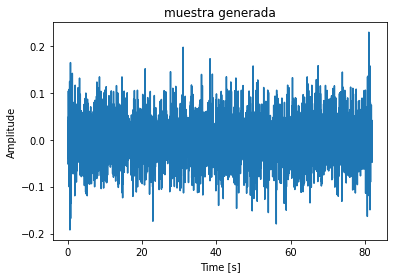

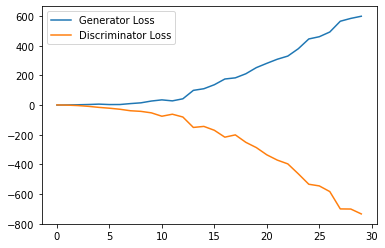

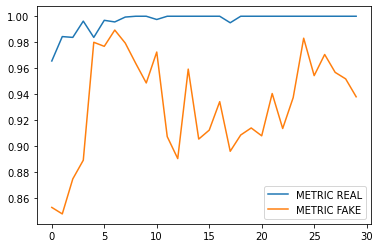

Step 650: Generator loss: 735.265830078125, discriminator loss: 0.0
Espectrogramas Generados


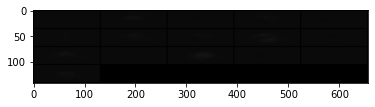

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


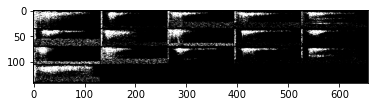

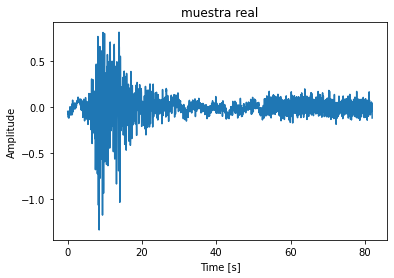

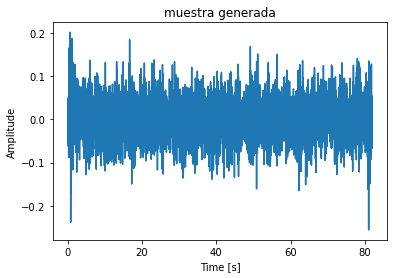

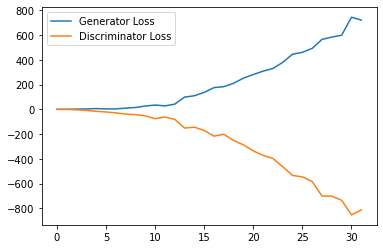

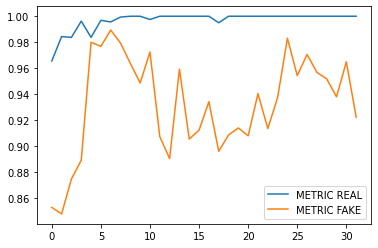

Step 700: Generator loss: 722.694833984375, discriminator loss: 0.0
Espectrogramas Generados


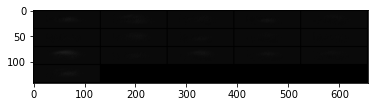

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


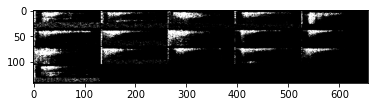

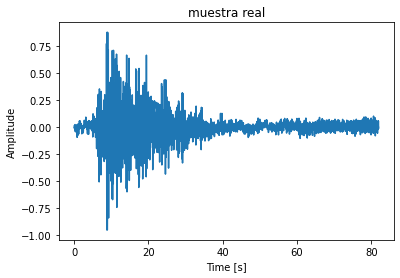

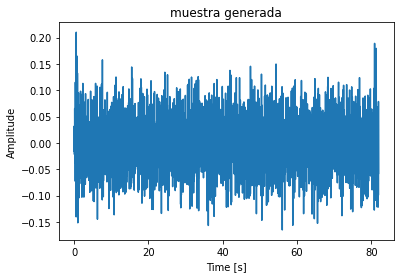

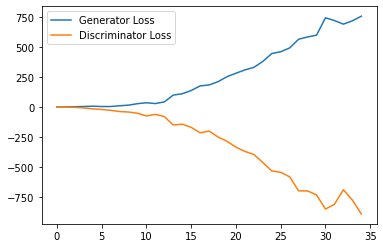

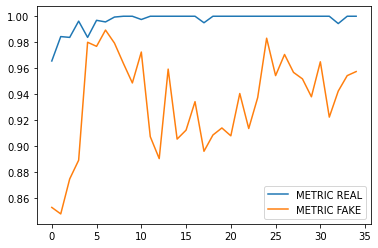

Step 750: Generator loss: 768.7442553710938, discriminator loss: 0.0
Espectrogramas Generados


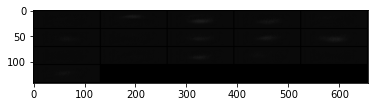

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


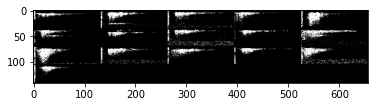

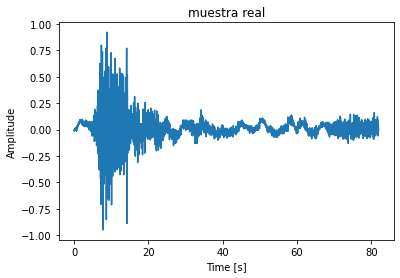

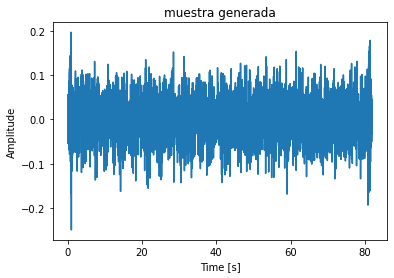

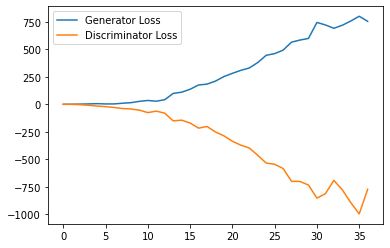

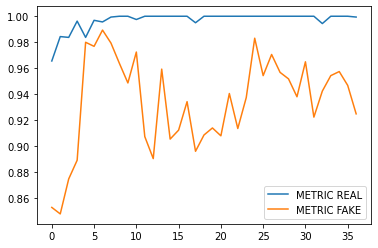

Epoch: 2


  0%|          | 0/385 [00:00<?, ?it/s]

Step 800: Generator loss: 724.84064453125, discriminator loss: 0.0
Espectrogramas Generados


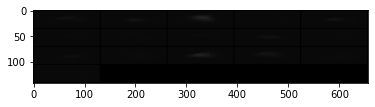

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


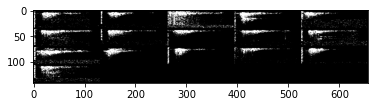

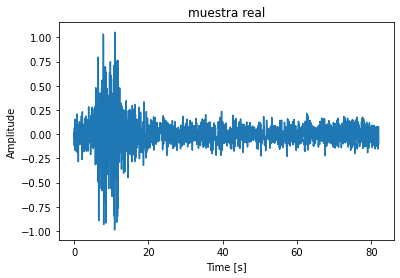

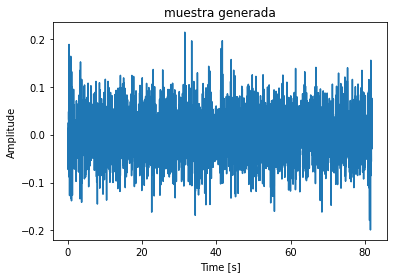

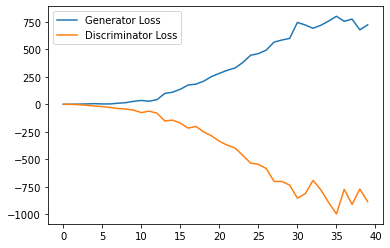

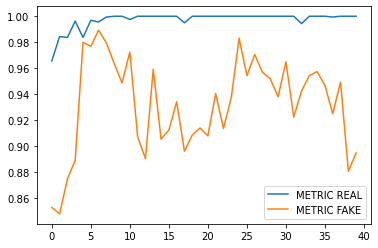

Step 850: Generator loss: 718.1421069335937, discriminator loss: 0.0
Espectrogramas Generados


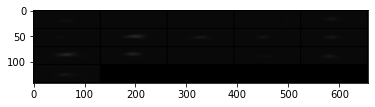

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


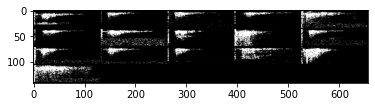

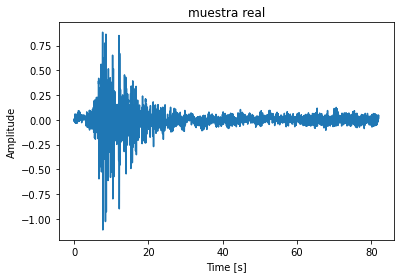

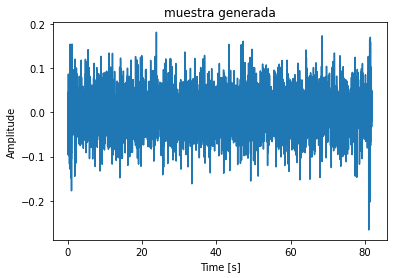

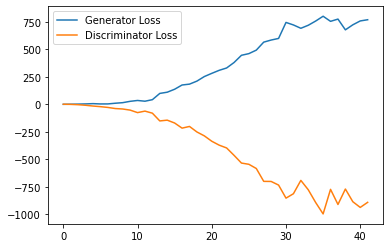

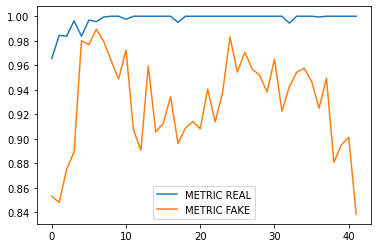

Step 900: Generator loss: 563.4227337646485, discriminator loss: 0.0
Espectrogramas Generados


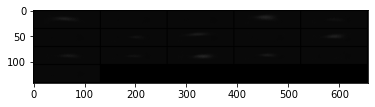

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


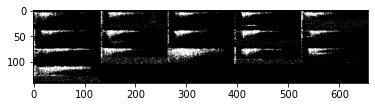

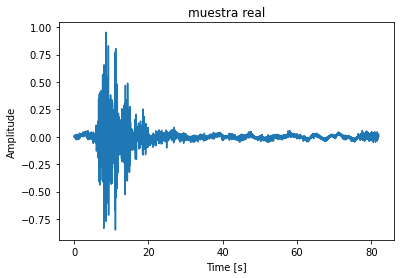

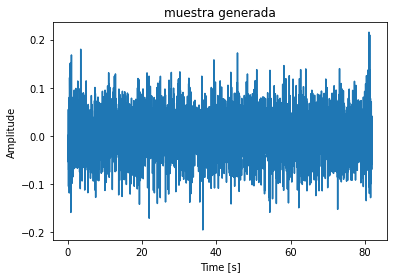

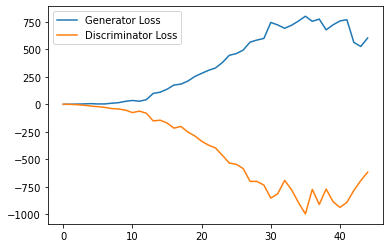

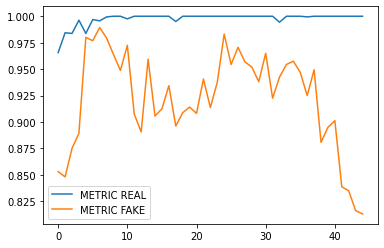

Step 950: Generator loss: 647.7675247192383, discriminator loss: 0.0
Espectrogramas Generados


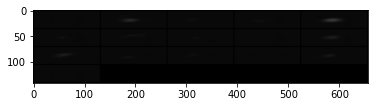

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


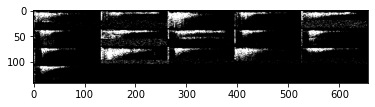

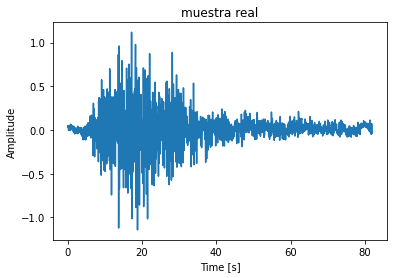

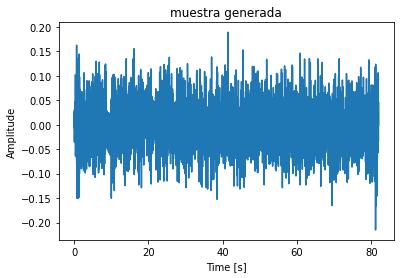

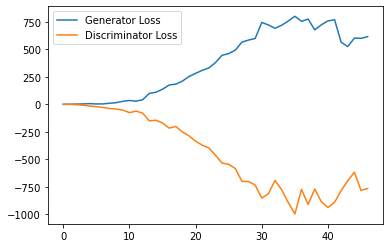

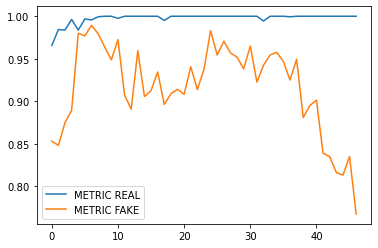

Step 1000: Generator loss: 653.780376586914, discriminator loss: 0.0
Espectrogramas Generados


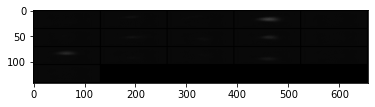

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


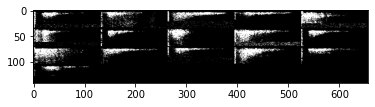

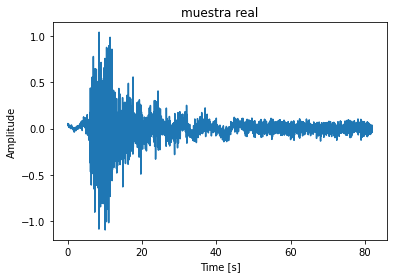

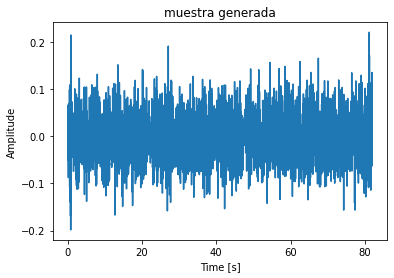

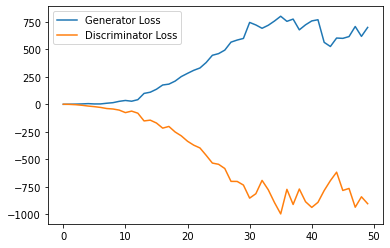

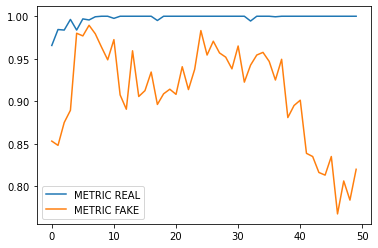

Step 1050: Generator loss: 631.3209130859375, discriminator loss: 0.0
Espectrogramas Generados


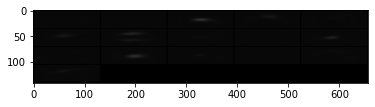

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


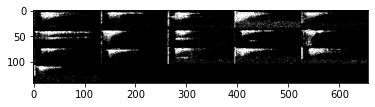

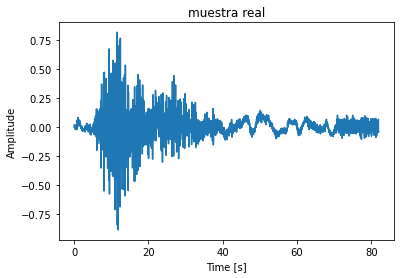

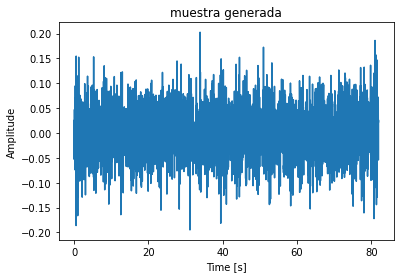

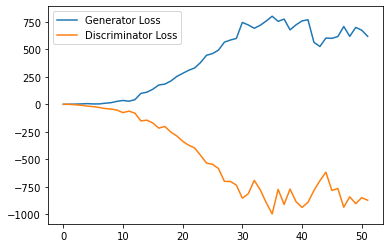

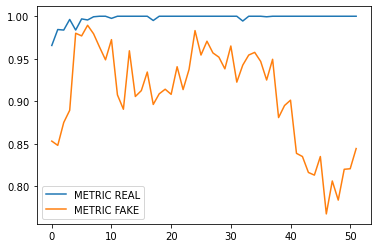

Step 1100: Generator loss: 570.6083447265624, discriminator loss: 0.0
Espectrogramas Generados


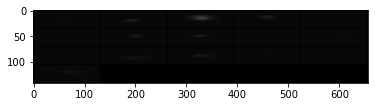

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


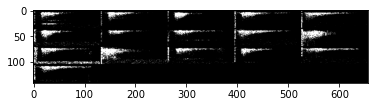

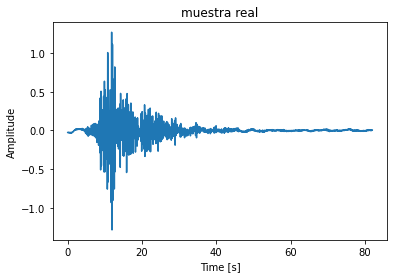

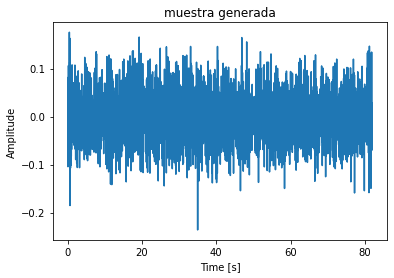

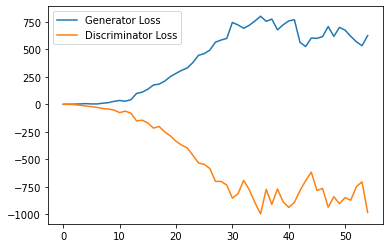

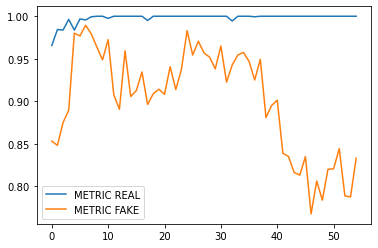

Step 1150: Generator loss: 646.791598815918, discriminator loss: 0.0
Espectrogramas Generados


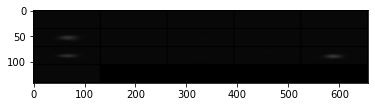

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


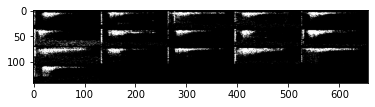

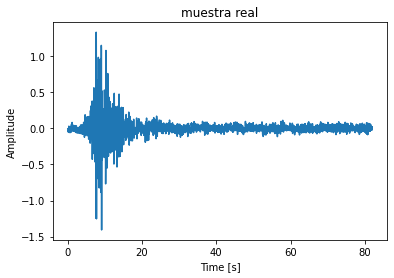

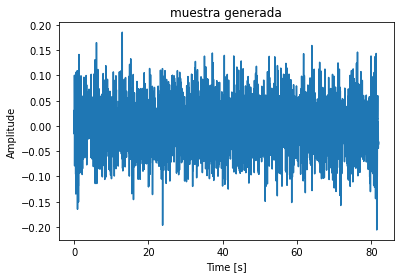

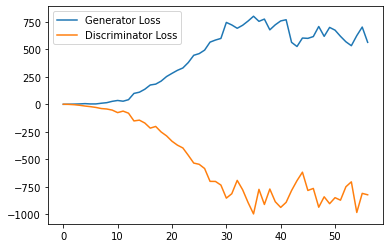

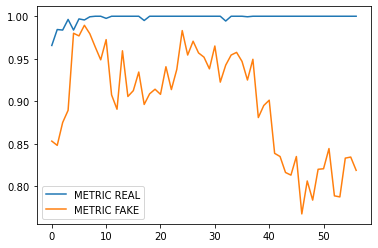

Epoch: 3


  0%|          | 0/385 [00:00<?, ?it/s]

Step 1200: Generator loss: 557.593971862793, discriminator loss: 0.0
Espectrogramas Generados


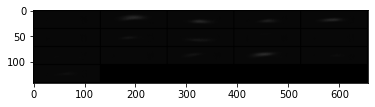

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


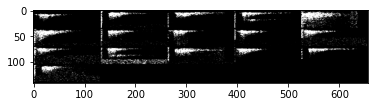

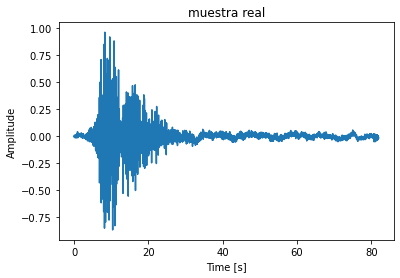

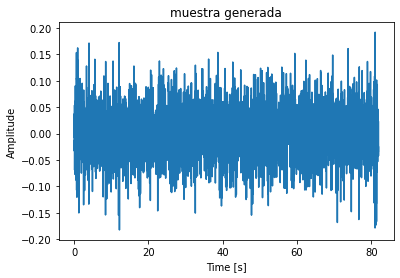

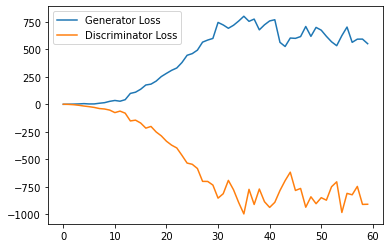

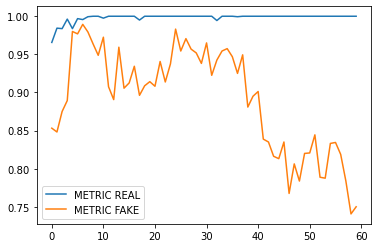

Step 1250: Generator loss: 623.5060629272461, discriminator loss: 0.0
Espectrogramas Generados


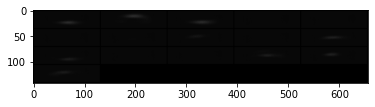

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


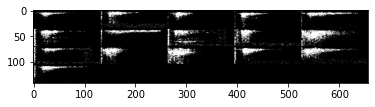

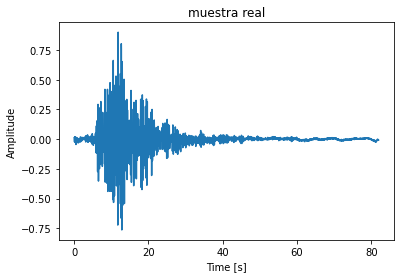

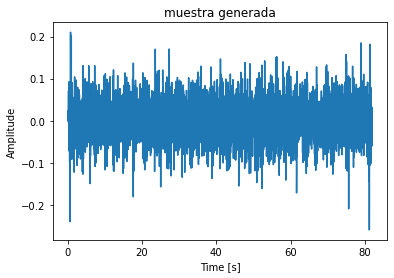

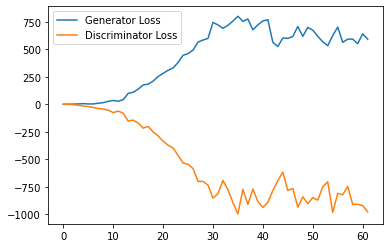

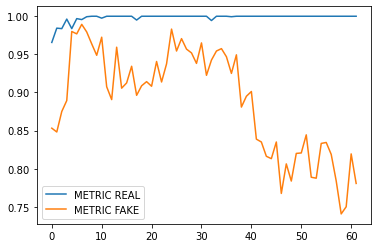

Step 1300: Generator loss: 622.5740661621094, discriminator loss: 0.0
Espectrogramas Generados


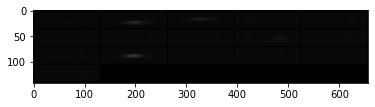

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


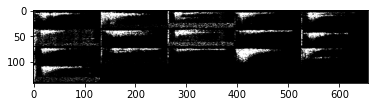

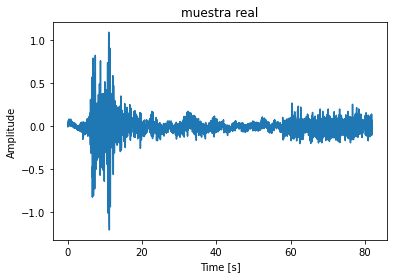

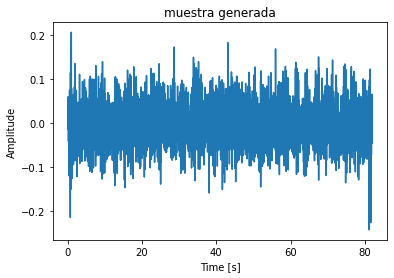

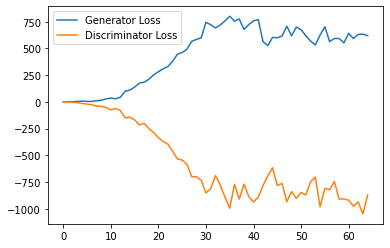

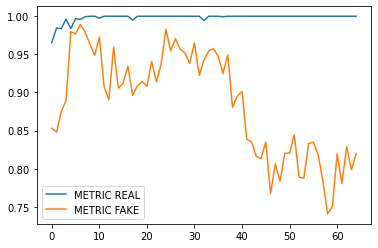

Step 1350: Generator loss: 633.3281469726562, discriminator loss: 0.0
Espectrogramas Generados


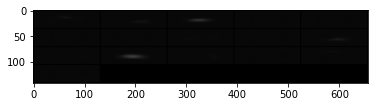

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


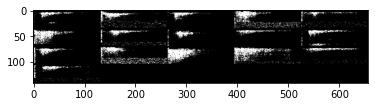

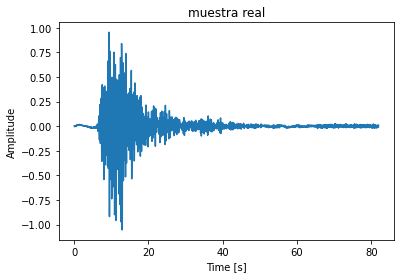

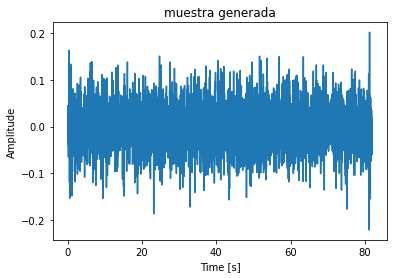

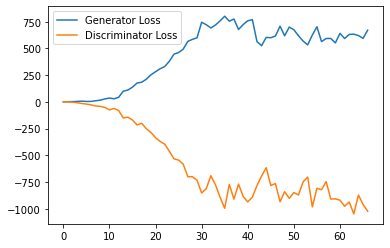

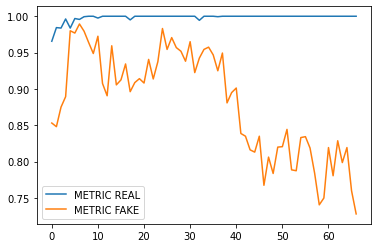

Step 1400: Generator loss: 635.9459606933593, discriminator loss: 0.0
Espectrogramas Generados


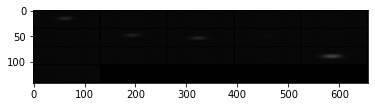

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


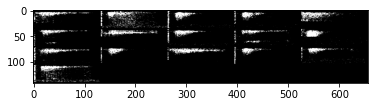

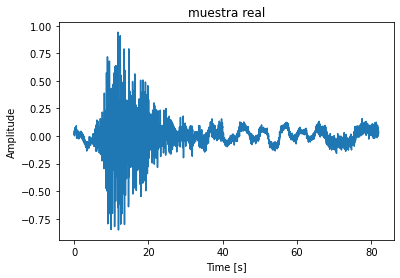

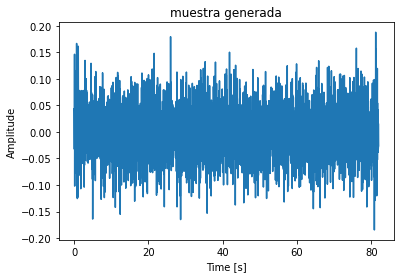

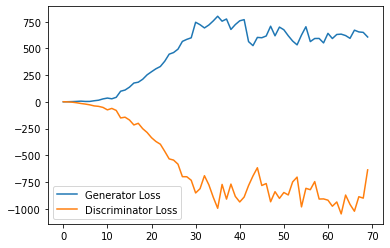

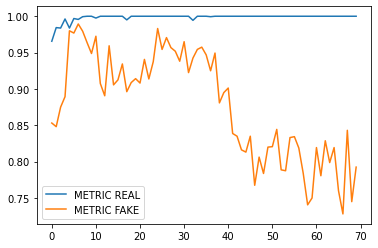

Step 1450: Generator loss: 703.857822265625, discriminator loss: 0.0
Espectrogramas Generados


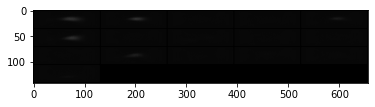

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


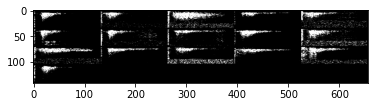

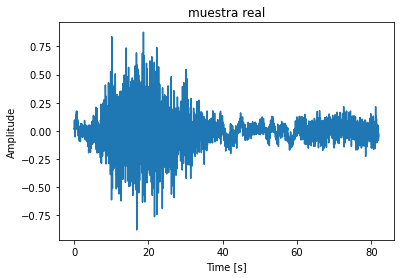

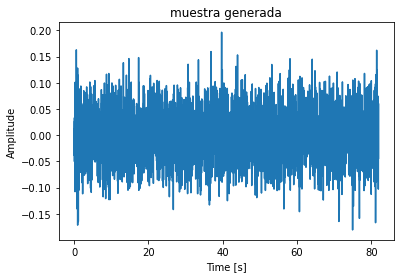

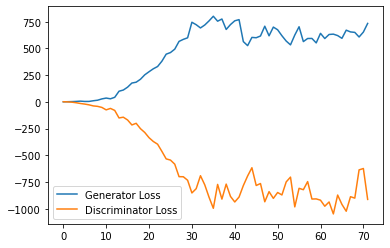

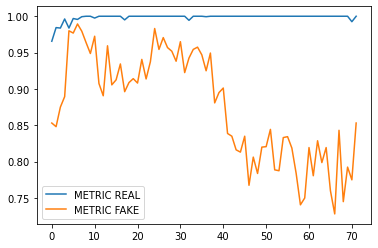

Step 1500: Generator loss: 687.2084368896484, discriminator loss: 0.0
Espectrogramas Generados


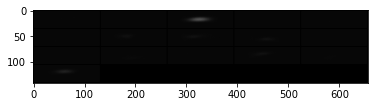

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


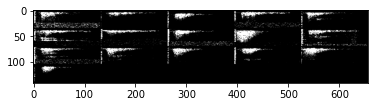

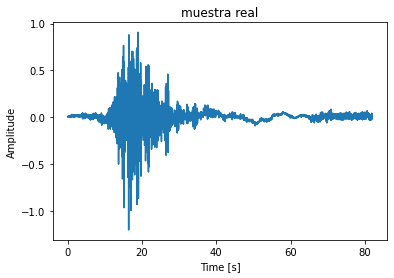

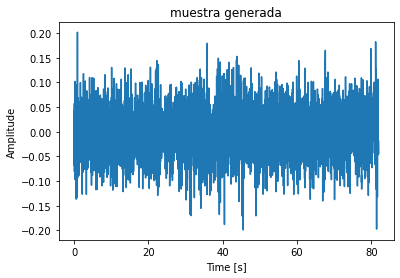

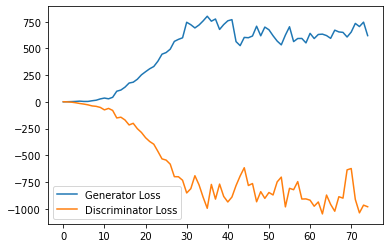

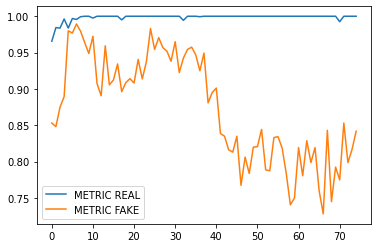

Epoch: 4


  0%|          | 0/385 [00:00<?, ?it/s]

Step 1550: Generator loss: 660.1831616210937, discriminator loss: 0.0
Espectrogramas Generados


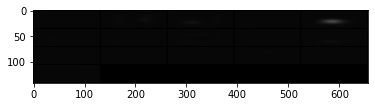

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


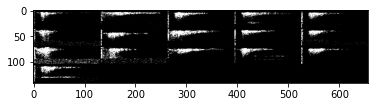

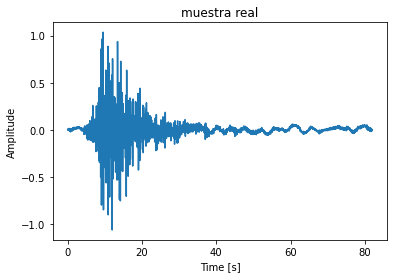

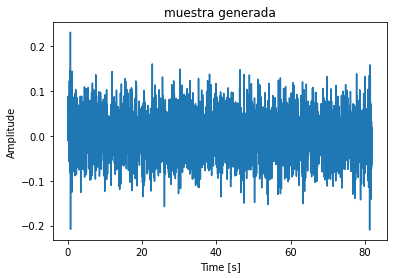

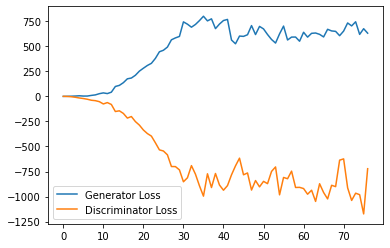

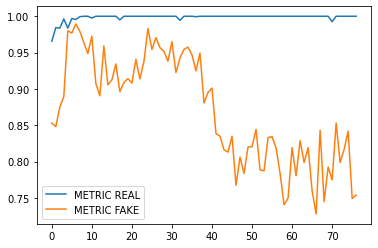

Step 1600: Generator loss: 662.905266418457, discriminator loss: 0.0
Espectrogramas Generados


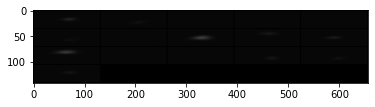

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


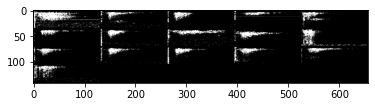

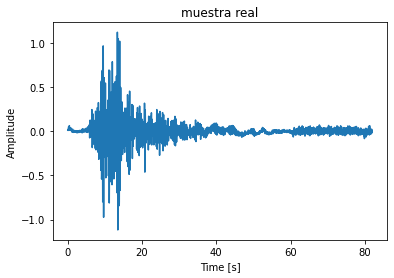

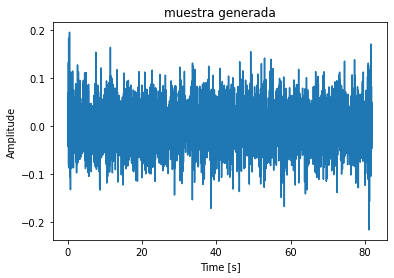

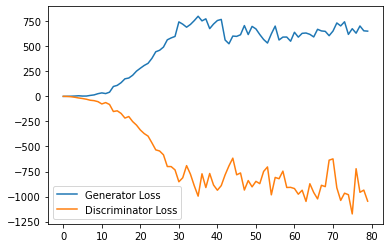

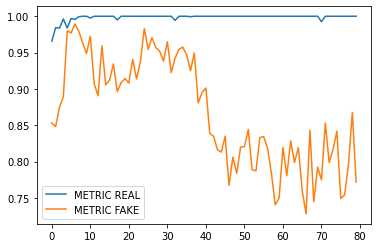

Step 1650: Generator loss: 633.7929922485351, discriminator loss: 0.0
Espectrogramas Generados


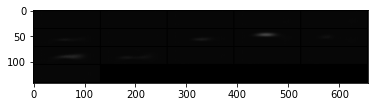

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


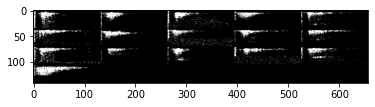

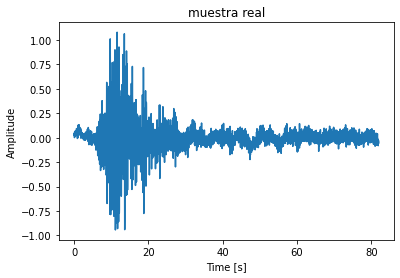

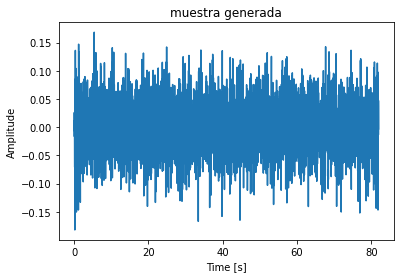

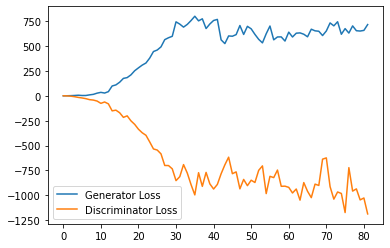

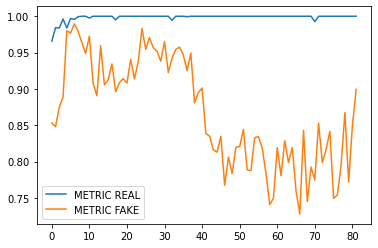

Step 1700: Generator loss: 629.8757577514648, discriminator loss: 0.0
Espectrogramas Generados


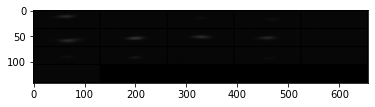

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


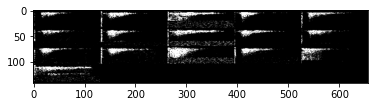

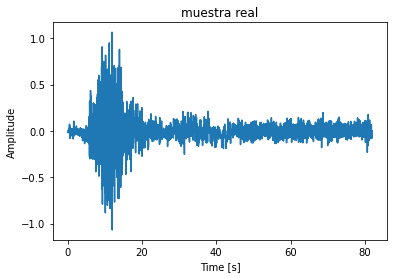

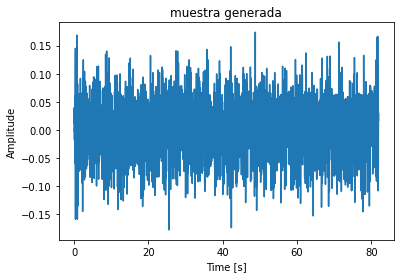

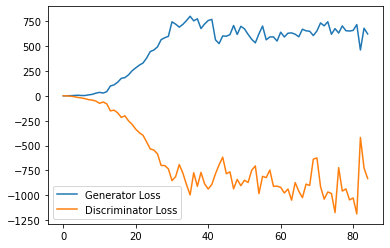

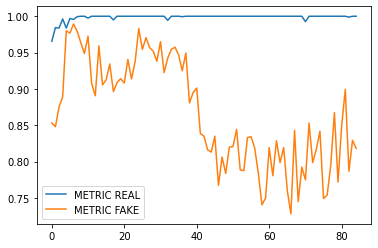

Step 1750: Generator loss: 698.9461206054688, discriminator loss: 0.0
Espectrogramas Generados


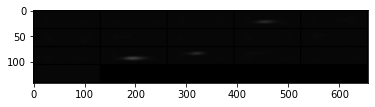

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


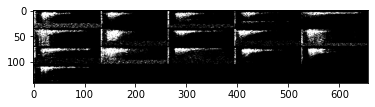

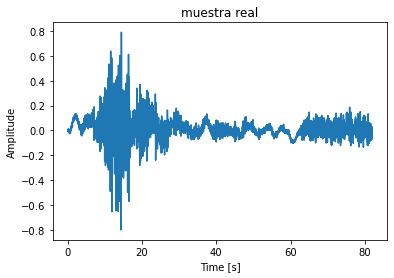

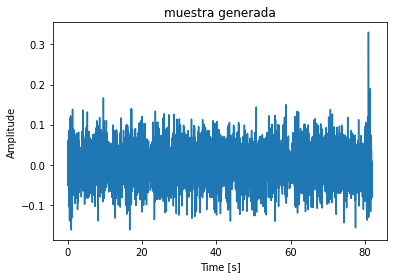

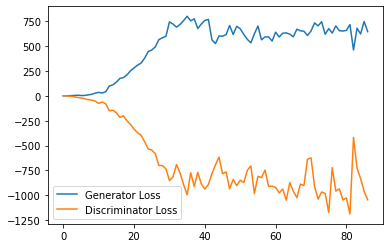

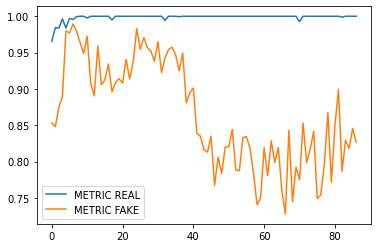

Step 1800: Generator loss: 704.8153332519531, discriminator loss: 0.0
Espectrogramas Generados


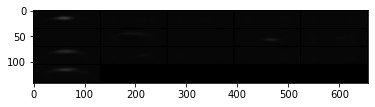

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


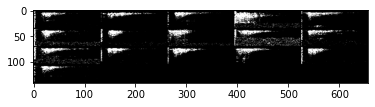

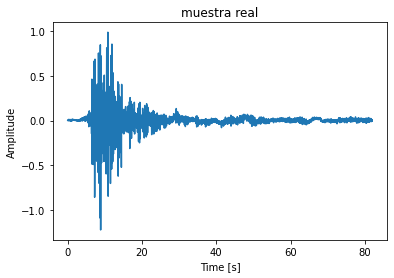

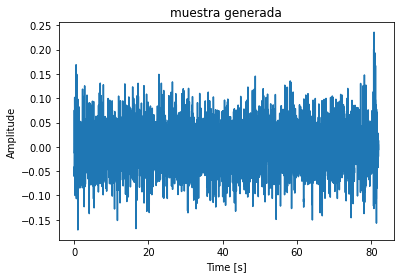

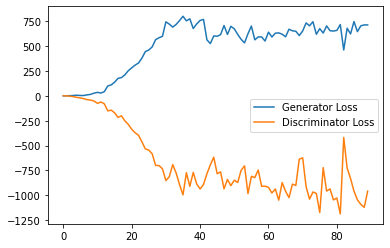

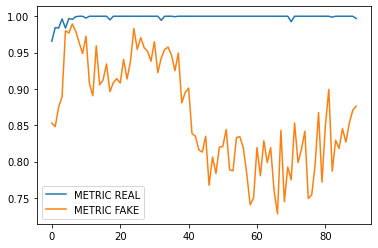

Step 1850: Generator loss: 732.2627044677735, discriminator loss: 0.0
Espectrogramas Generados


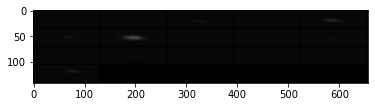

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


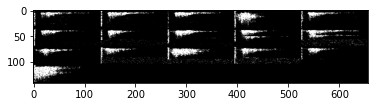

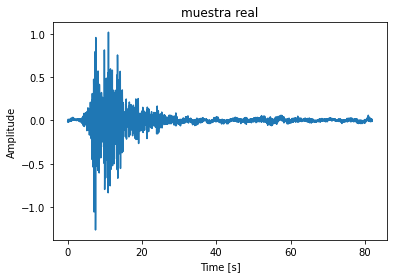

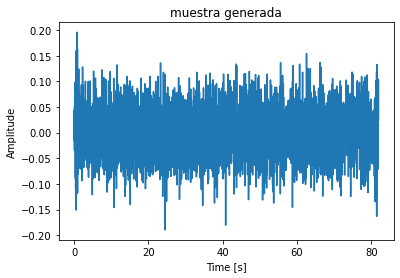

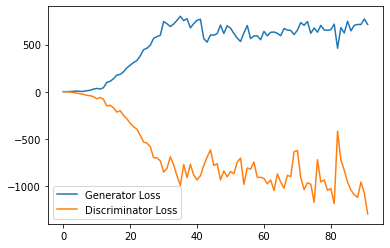

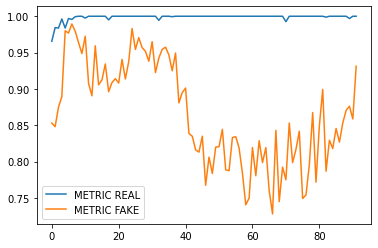

Step 1900: Generator loss: 643.9989297485351, discriminator loss: 0.0
Espectrogramas Generados


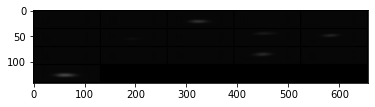

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


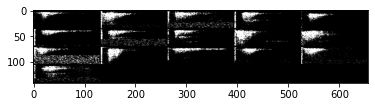

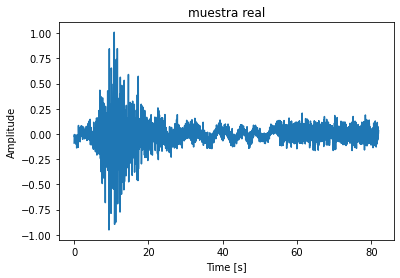

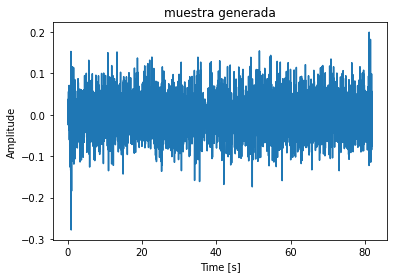

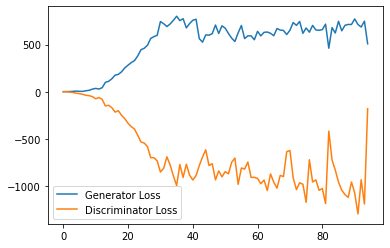

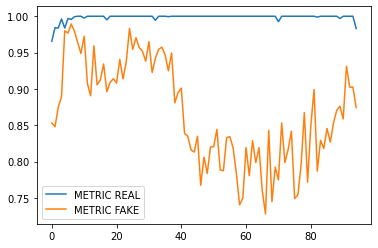

Epoch: 5


  0%|          | 0/385 [00:00<?, ?it/s]

Step 1950: Generator loss: 692.1165493774414, discriminator loss: 0.0
Espectrogramas Generados


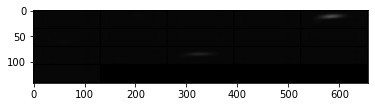

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


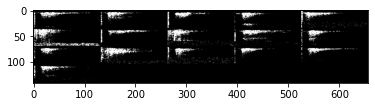

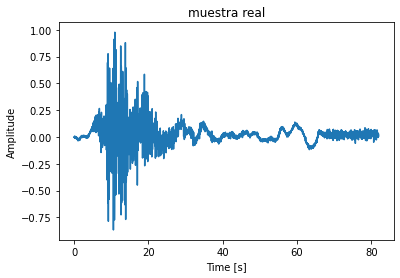

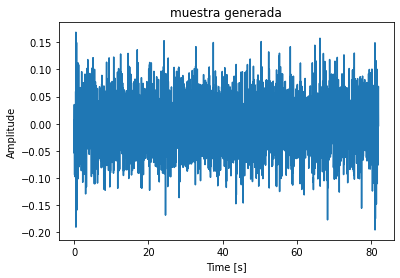

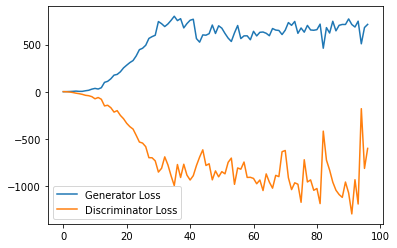

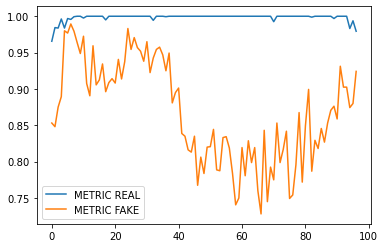

Step 2000: Generator loss: 749.7239758300781, discriminator loss: 0.0
Espectrogramas Generados


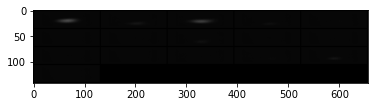

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


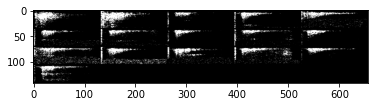

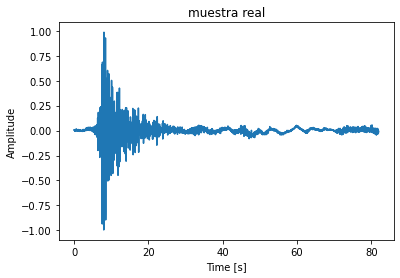

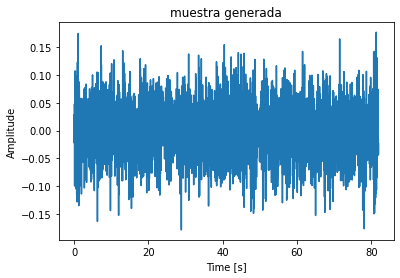

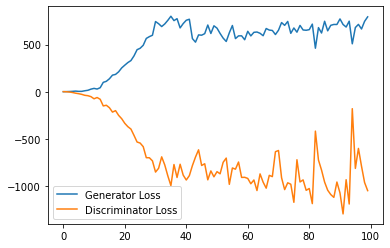

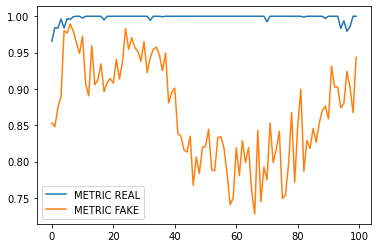

Step 2050: Generator loss: 797.3475219726563, discriminator loss: 0.0
Espectrogramas Generados


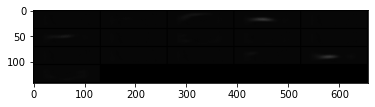

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


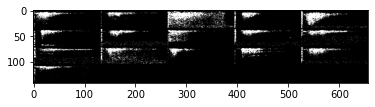

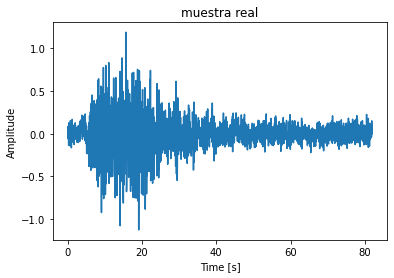

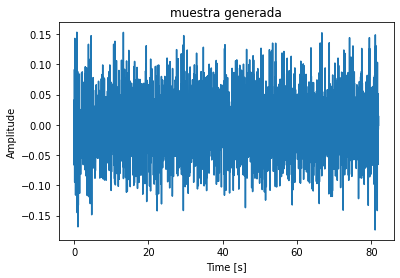

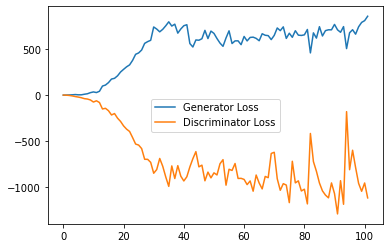

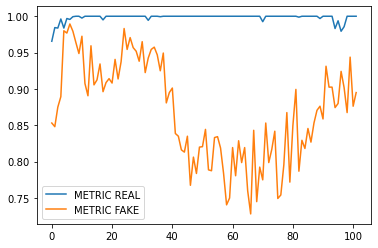

Step 2100: Generator loss: 908.3720574951171, discriminator loss: 0.0
Espectrogramas Generados


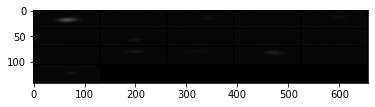

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


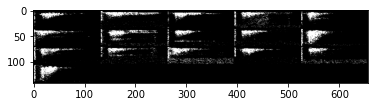

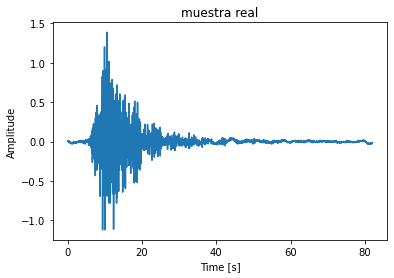

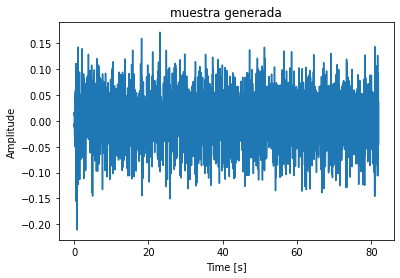

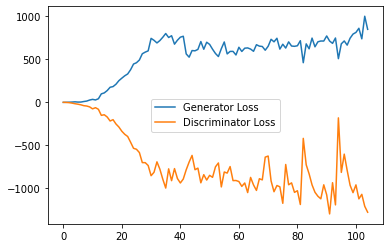

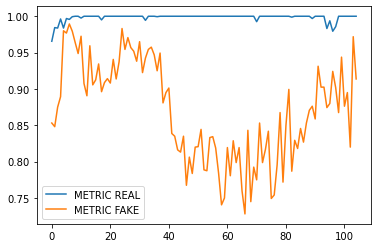

Step 2150: Generator loss: 790.8058758544922, discriminator loss: 0.0
Espectrogramas Generados


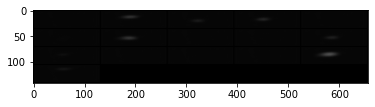

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


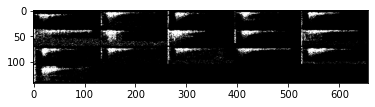

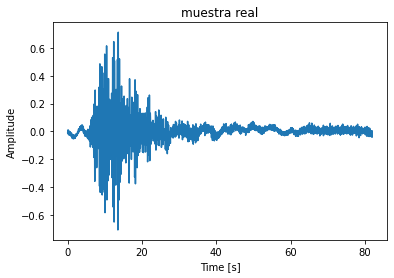

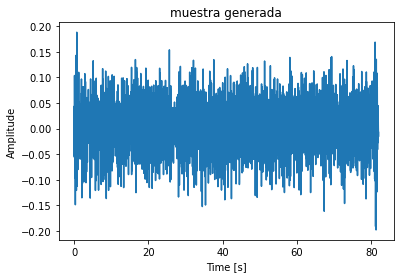

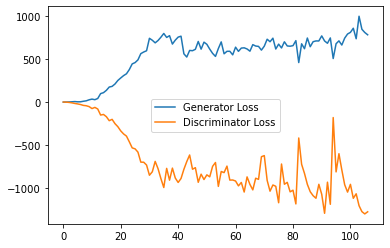

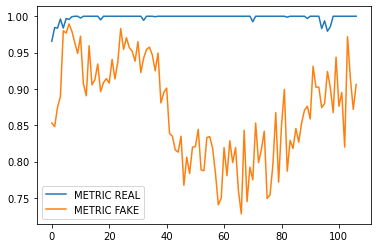

Step 2200: Generator loss: 804.3660296630859, discriminator loss: 0.0
Espectrogramas Generados


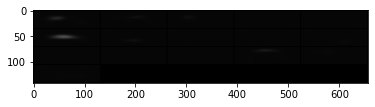

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


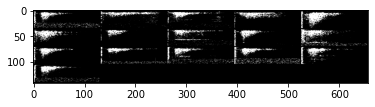

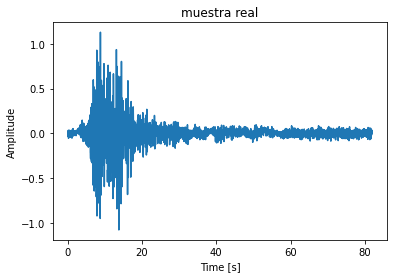

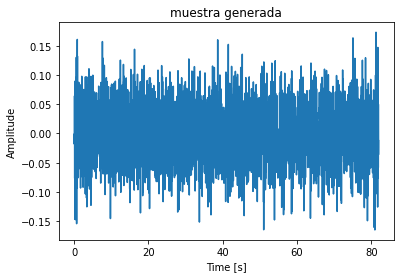

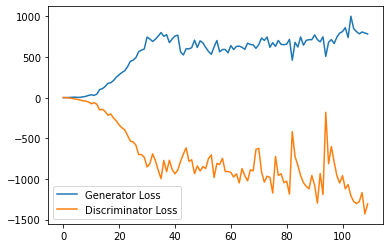

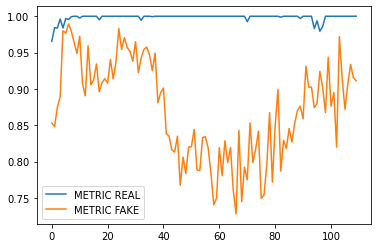

Step 2250: Generator loss: 921.4653247070313, discriminator loss: 0.0
Espectrogramas Generados


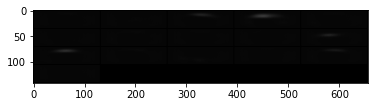

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


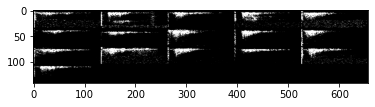

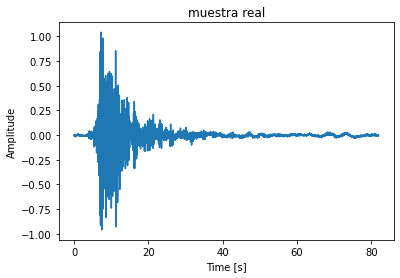

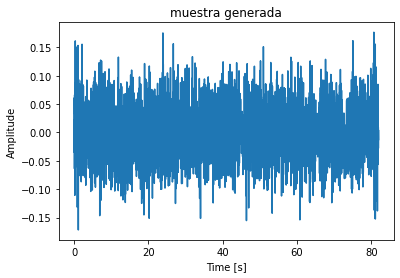

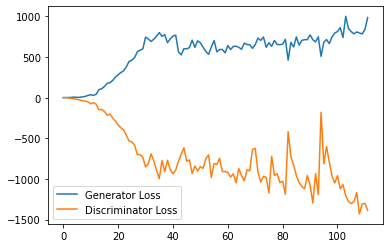

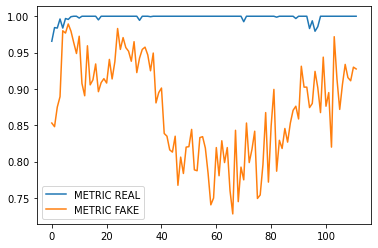

Step 2300: Generator loss: 900.1608239746093, discriminator loss: 0.0
Espectrogramas Generados


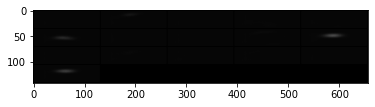

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


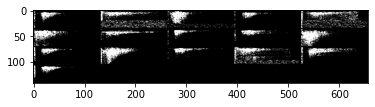

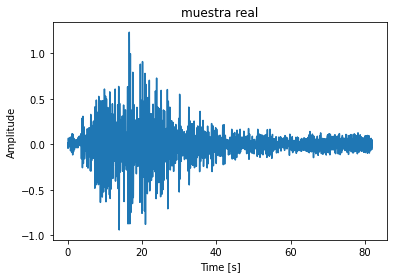

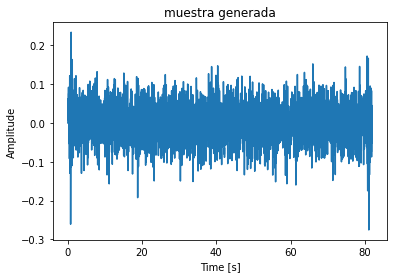

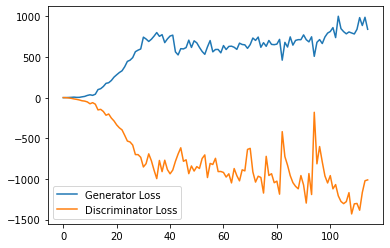

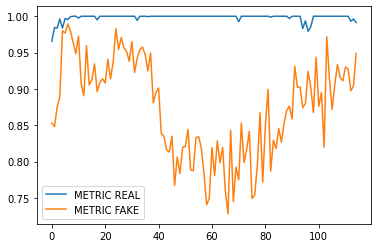

Epoch: 6


  0%|          | 0/385 [00:00<?, ?it/s]

Step 2350: Generator loss: 883.6337896728515, discriminator loss: 0.0
Espectrogramas Generados


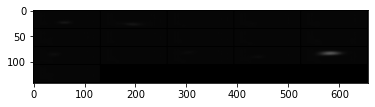

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


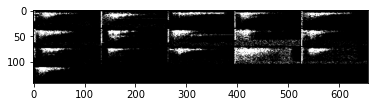

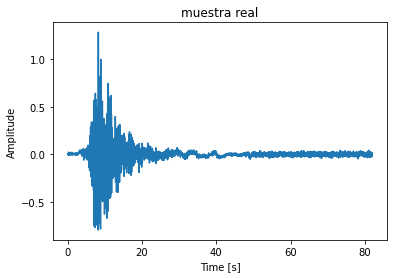

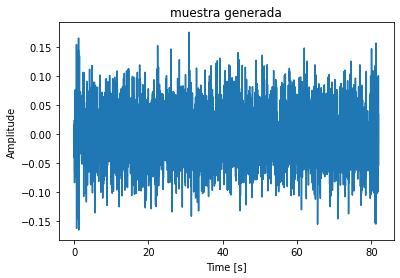

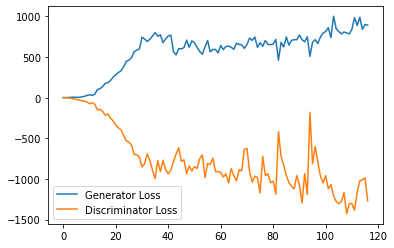

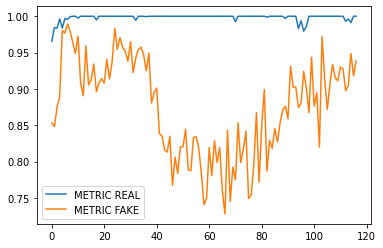

Step 2400: Generator loss: 987.1084802246094, discriminator loss: 0.0
Espectrogramas Generados


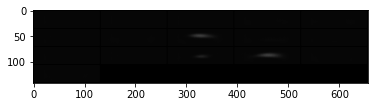

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


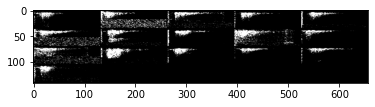

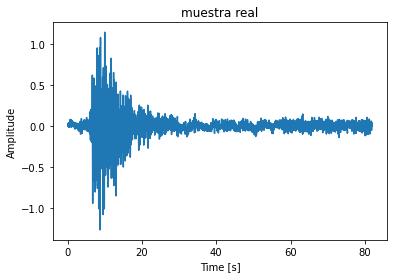

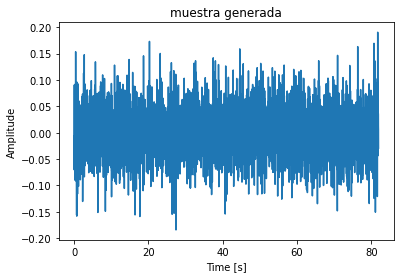

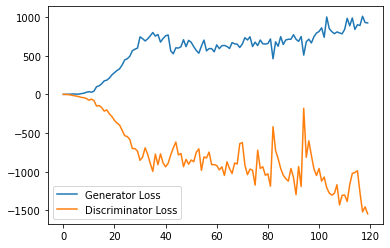

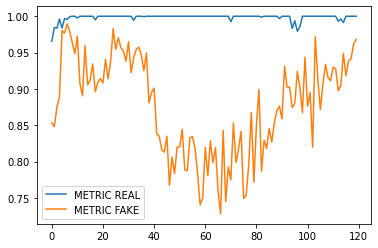

Step 2450: Generator loss: 969.2141198730469, discriminator loss: 0.0
Espectrogramas Generados


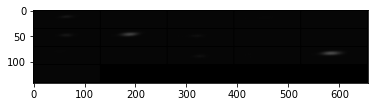

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


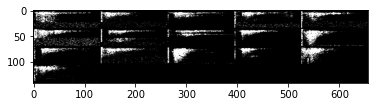

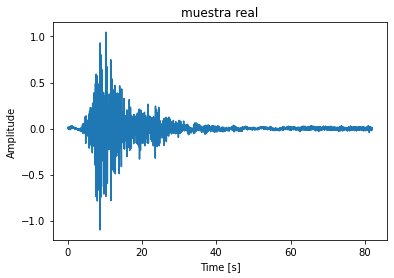

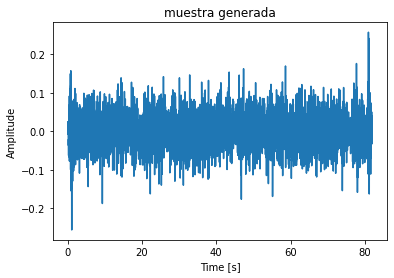

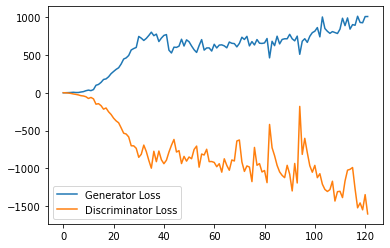

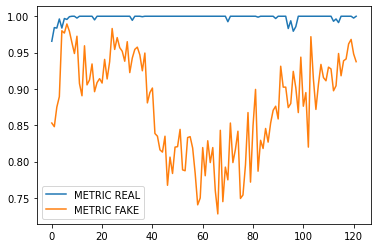

Step 2500: Generator loss: 958.6816137695313, discriminator loss: 0.0
Espectrogramas Generados


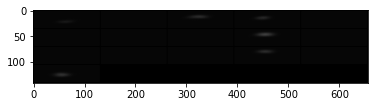

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


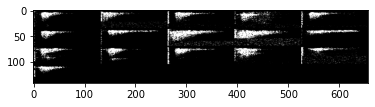

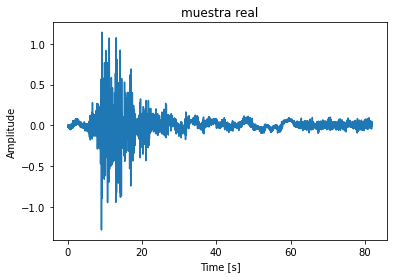

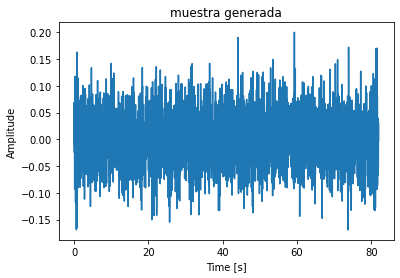

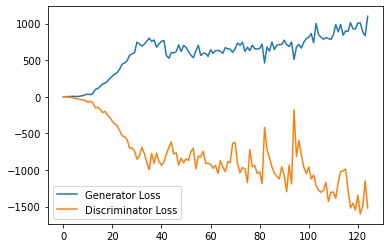

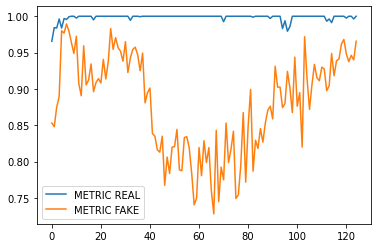

Step 2550: Generator loss: 885.1072100830078, discriminator loss: 0.0
Espectrogramas Generados


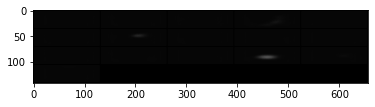

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


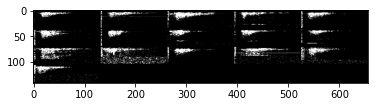

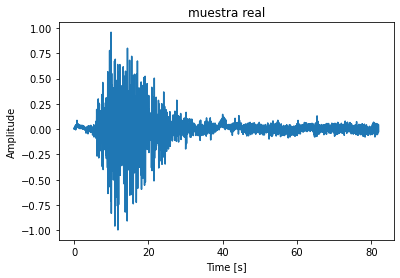

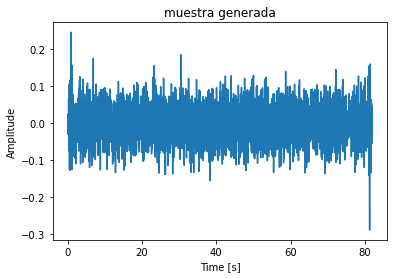

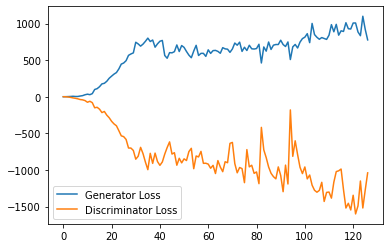

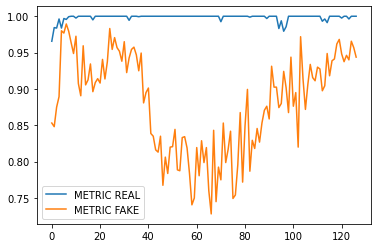

Step 2600: Generator loss: 980.7847143554687, discriminator loss: 0.0
Espectrogramas Generados


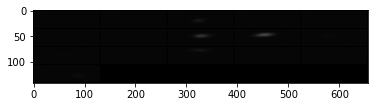

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


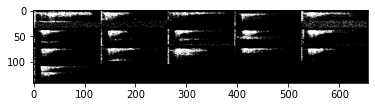

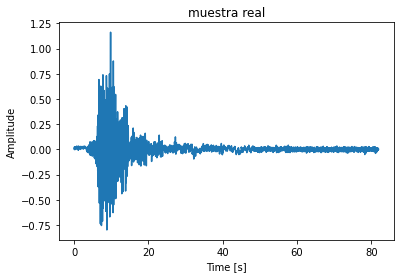

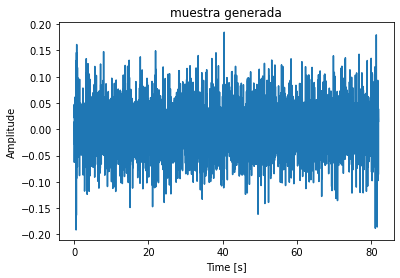

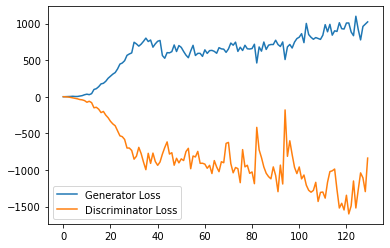

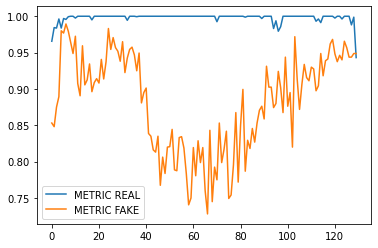

Step 2650: Generator loss: 1091.2616296386718, discriminator loss: 0.0
Espectrogramas Generados


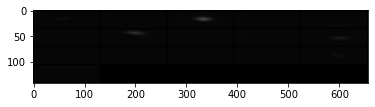

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


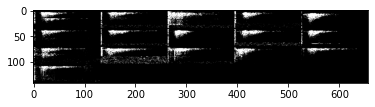

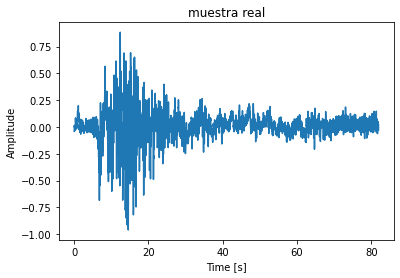

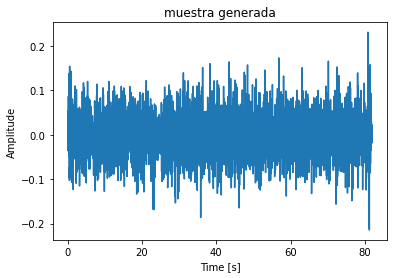

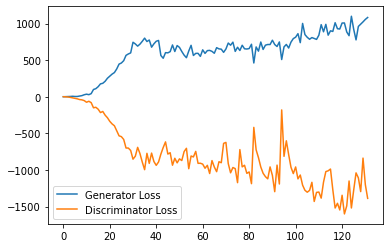

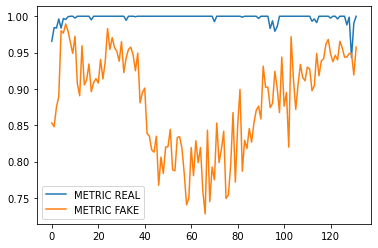

Epoch: 7


  0%|          | 0/385 [00:00<?, ?it/s]

Step 2700: Generator loss: 957.6510620117188, discriminator loss: 0.0
Espectrogramas Generados


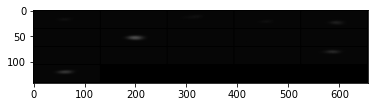

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


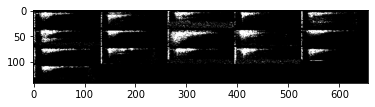

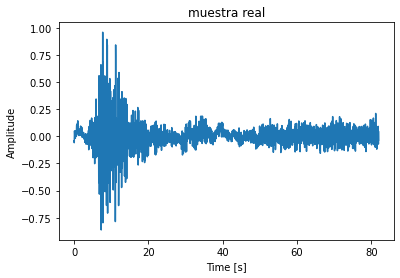

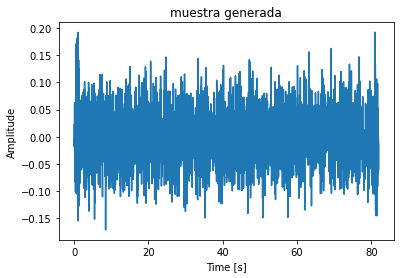

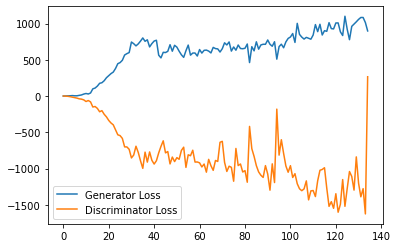

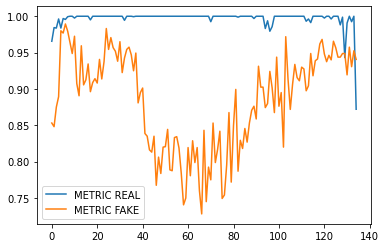

Step 2750: Generator loss: 1044.275157470703, discriminator loss: 0.0
Espectrogramas Generados


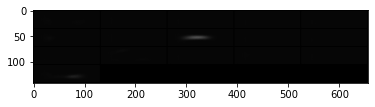

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


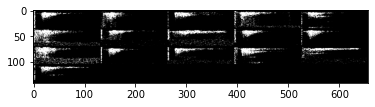

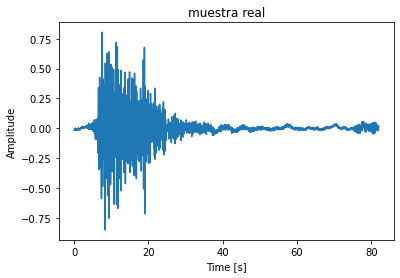

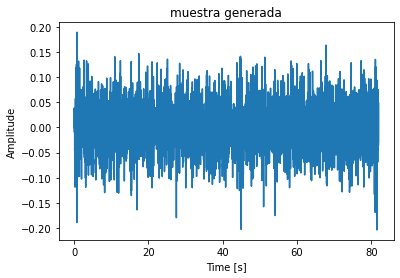

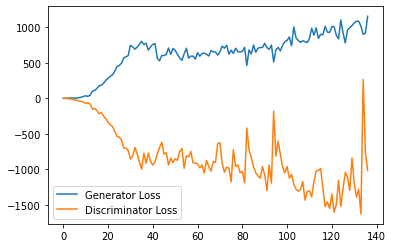

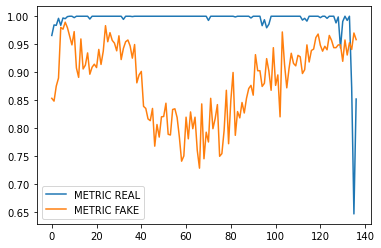

Step 2800: Generator loss: 1160.6391955566405, discriminator loss: 0.0
Espectrogramas Generados


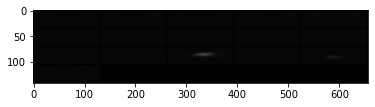

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


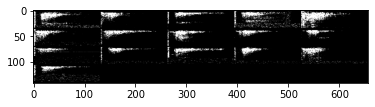

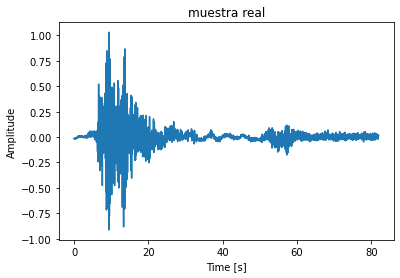

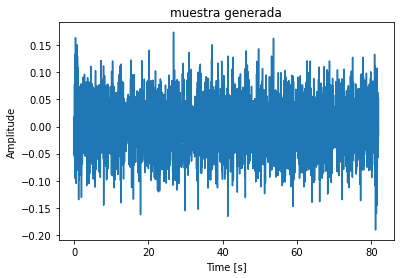

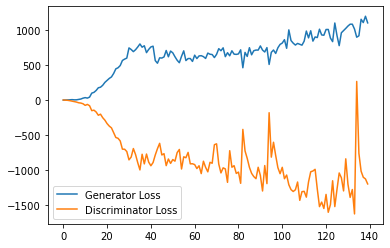

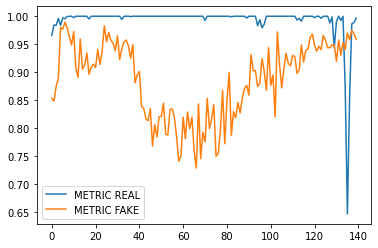

Step 2850: Generator loss: 1182.2282556152343, discriminator loss: 0.0
Espectrogramas Generados


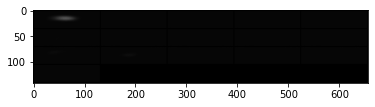

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


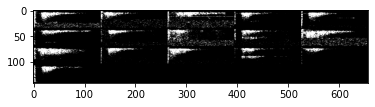

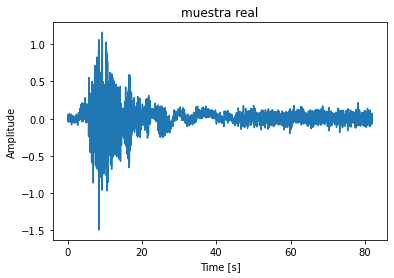

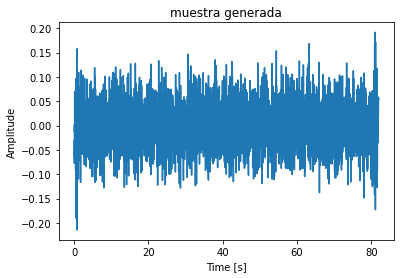

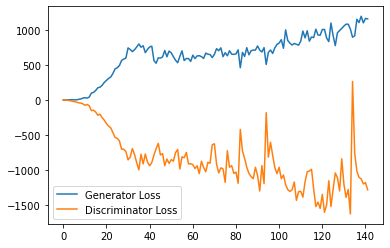

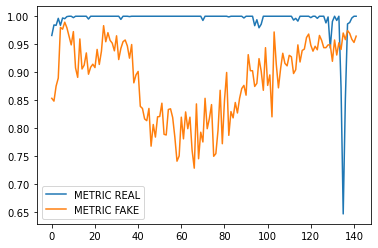

Step 2900: Generator loss: 1069.758218688965, discriminator loss: 0.0
Espectrogramas Generados


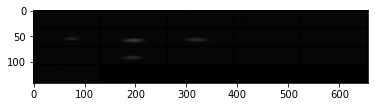

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


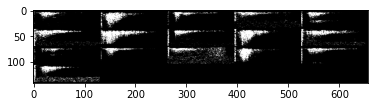

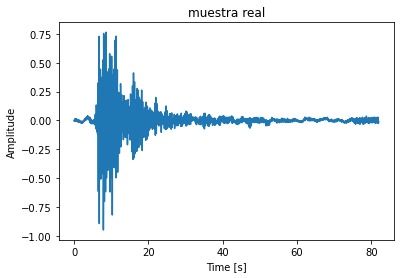

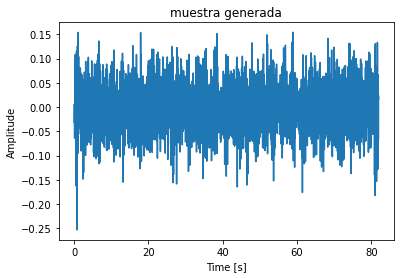

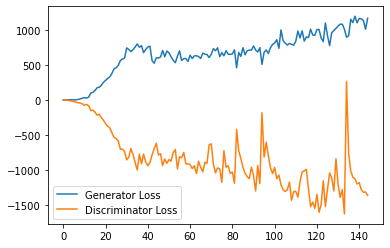

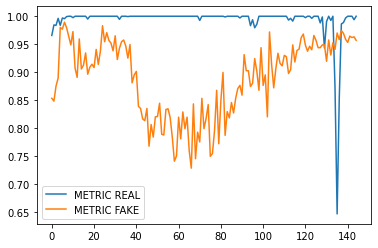

Step 2950: Generator loss: 1168.3540063476562, discriminator loss: 0.0
Espectrogramas Generados


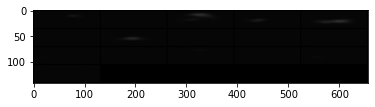

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


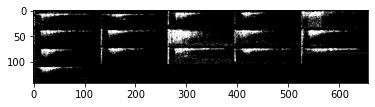

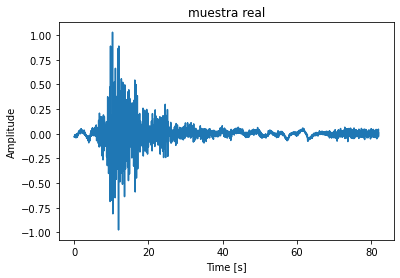

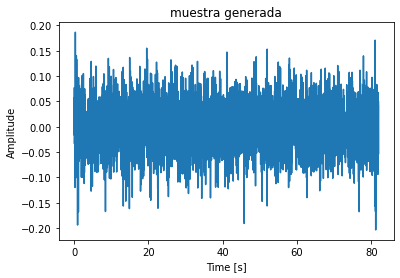

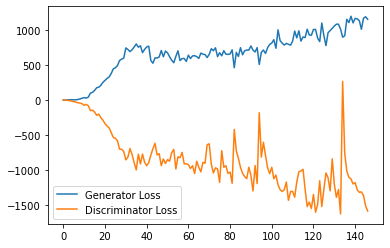

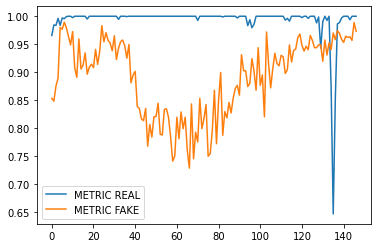

Step 3000: Generator loss: 1133.3397534179687, discriminator loss: 0.0
Espectrogramas Generados


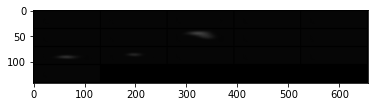

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


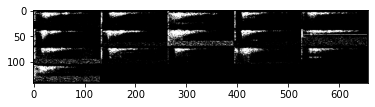

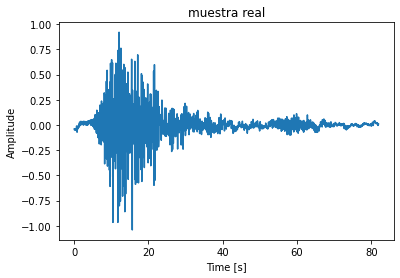

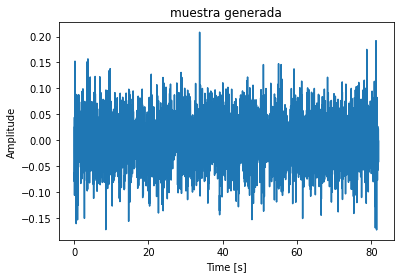

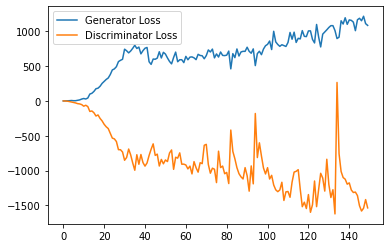

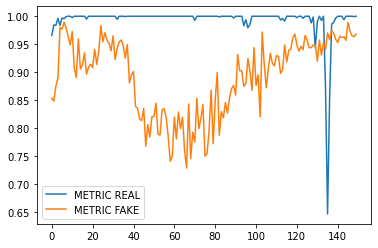

Step 3050: Generator loss: 1210.8752941894531, discriminator loss: 0.0
Espectrogramas Generados


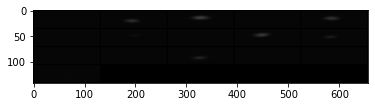

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


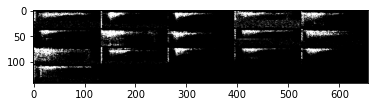

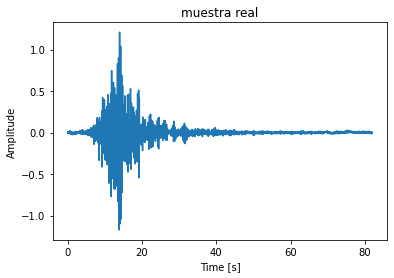

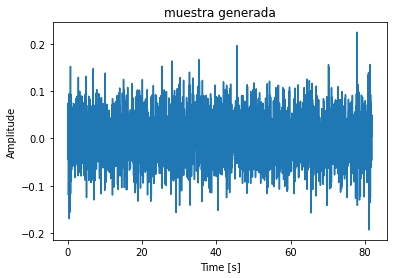

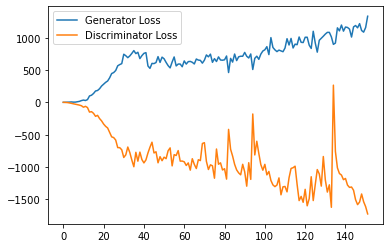

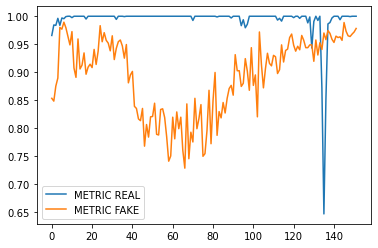

Epoch: 8


  0%|          | 0/385 [00:00<?, ?it/s]

Step 3100: Generator loss: 1143.1627258300782, discriminator loss: 0.0
Espectrogramas Generados


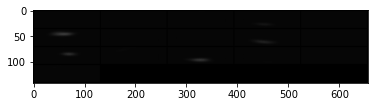

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


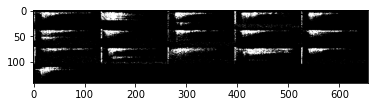

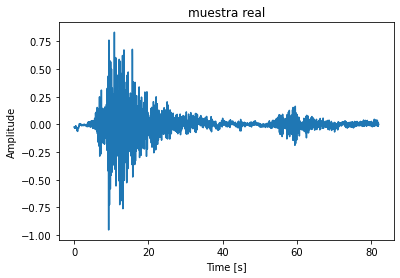

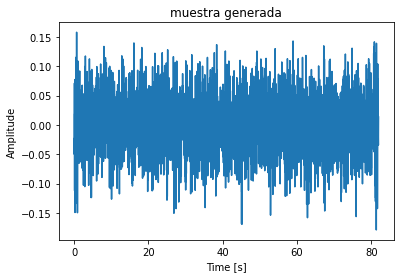

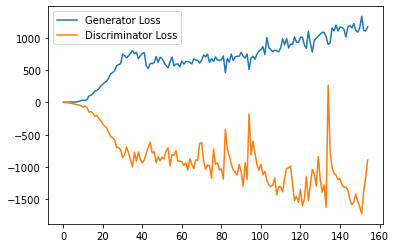

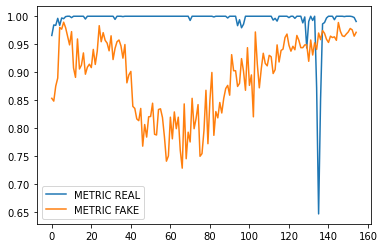

Step 3150: Generator loss: 1302.7304345703126, discriminator loss: 0.0
Espectrogramas Generados


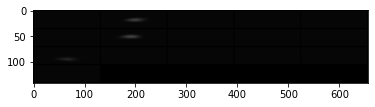

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


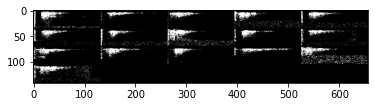

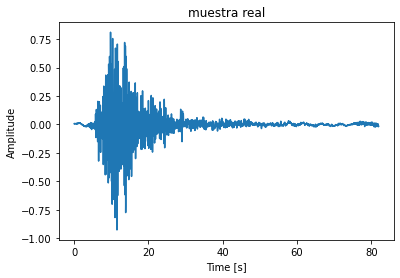

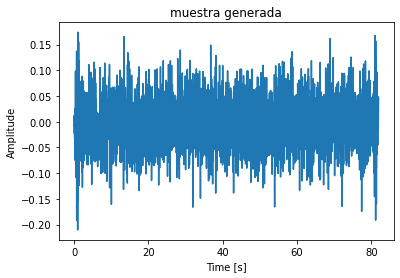

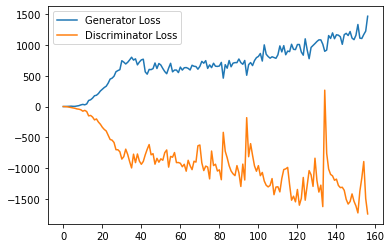

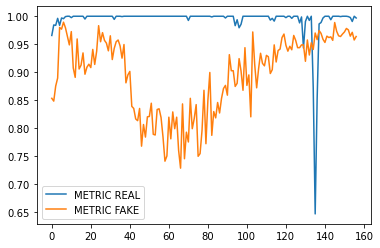

Step 3200: Generator loss: 1270.2025866699219, discriminator loss: 0.0
Espectrogramas Generados


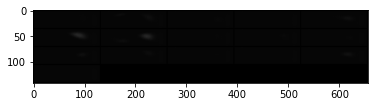

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


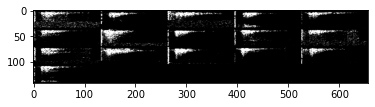

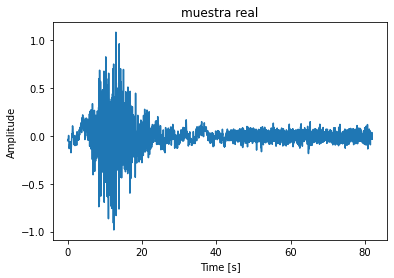

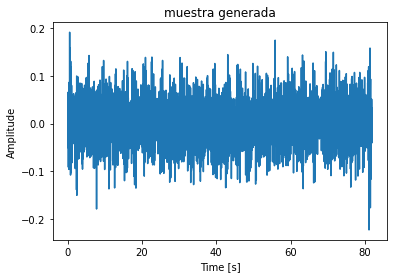

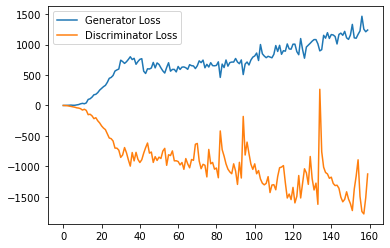

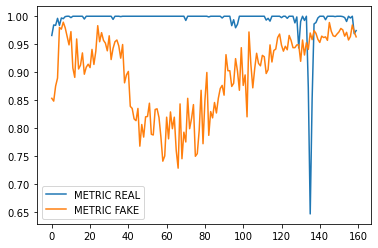

Step 3250: Generator loss: 1260.596209716797, discriminator loss: 0.0
Espectrogramas Generados


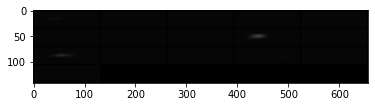

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


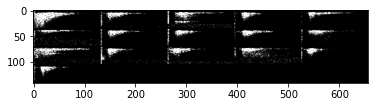

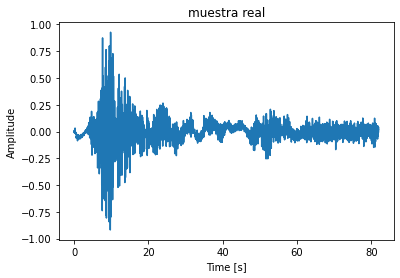

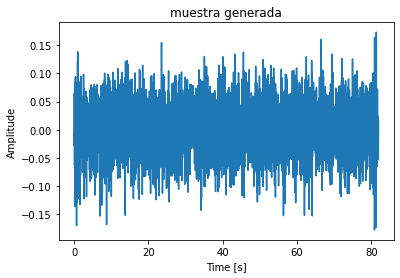

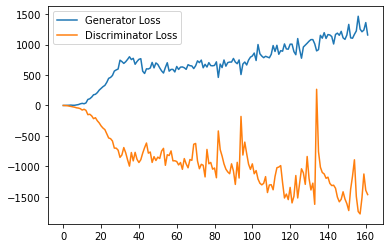

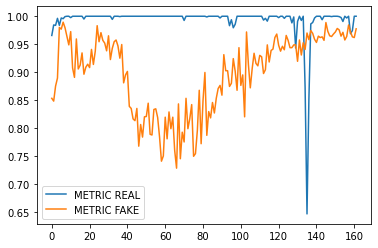

Step 3300: Generator loss: 1344.802049560547, discriminator loss: 0.0
Espectrogramas Generados


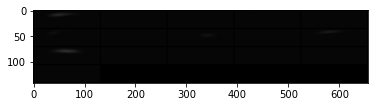

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


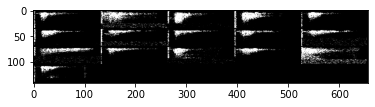

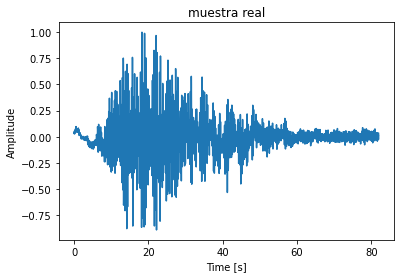

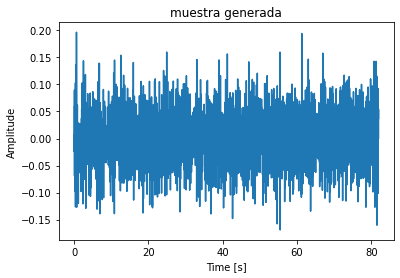

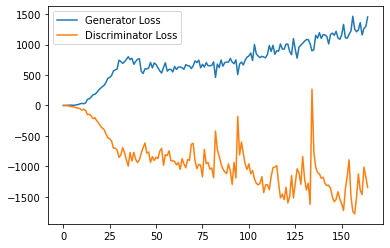

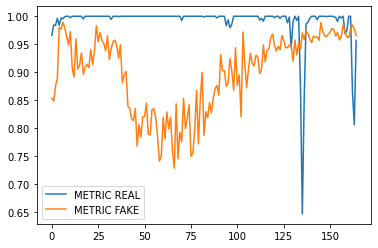

Step 3350: Generator loss: 1308.8083178710938, discriminator loss: 0.0
Espectrogramas Generados


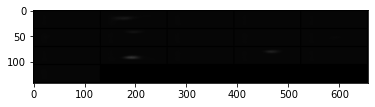

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


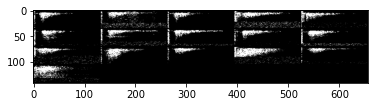

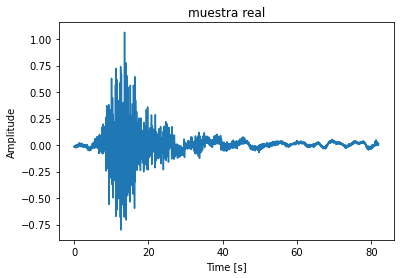

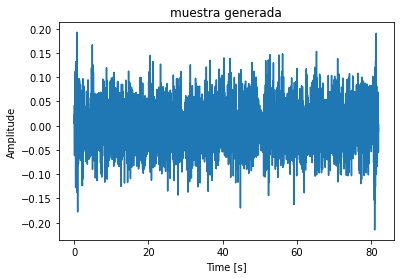

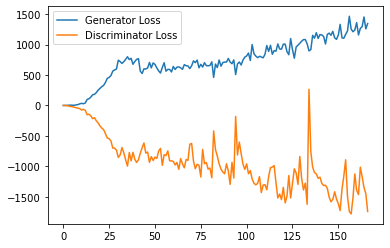

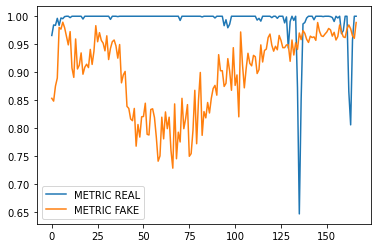

Step 3400: Generator loss: 1370.062158203125, discriminator loss: 0.0
Espectrogramas Generados


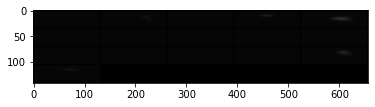

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Espectrogramas Reales


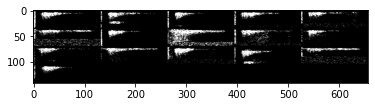

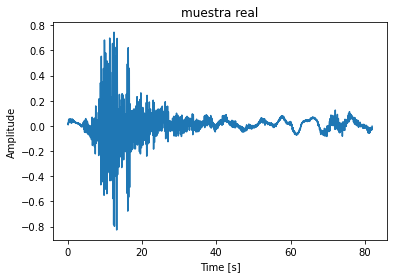

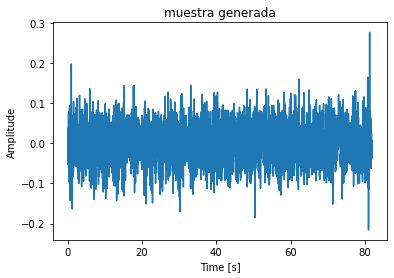

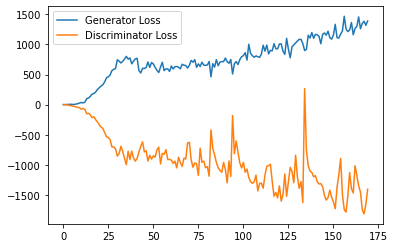

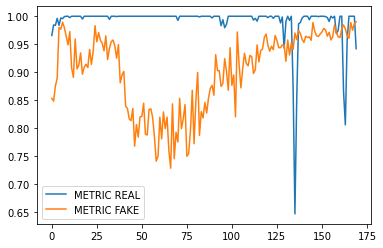

In [ ]:
generator_losses = []
discriminator_losses = []
discriminator_losses_real = []
discriminator_losses_fake = []
metric_real = []
metric_fake = [] 
critic_losses = []
cur_step = 0

for epoch in range(epoch_temp + 1, n_epochs):
    print('Epoch: ' + str(epoch))
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)              
        mean_iteration_critic_loss = 0
        mean_metric_fake = 0
        mean_metric_real = 0
        for _ in range(crit_repeats):
            one_hot_labels = auxiliares.get_one_hot_labels(labels.to(device), n_classes)
            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

            ### Update discriminator ###
            # Zero out the discriminator gradients
            disc_opt.zero_grad()
            # Get noise corresponding to the current batch_size 
            fake_noise = auxiliares.get_noise(cur_batch_size, z_dim, device=device)
        
            # Now you can get the images from the generator
            # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
            #        2) Generate the conditioned fake images
       
            noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)#gen.forward(noise_and_labels) no usar

            # Now you can get the predictions from the discriminator
            # Steps: 1) Create the input for the discriminator
            #           a) Combine the fake images with image_one_hot_labels, 
            #              remember to detach the generator (.detach()) so you do not backpropagate through it
            #           b) Combine the real images with image_one_hot_labels
            #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
            #        3) Get the discriminator's prediction on the reals as disc_real_pred
        
            fake_image_and_labels = auxiliares.combine_vectors(fake, image_one_hot_labels)
            real_image_and_labels = auxiliares.combine_vectors(real, image_one_hot_labels)
            disc_fake_pred = disc(fake_image_and_labels.detach())
            disc_real_pred = disc(real_image_and_labels)
        
            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(disc, real_image_and_labels, fake_image_and_labels.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(disc_fake_pred, disc_real_pred, gp, c_lambda)
            
             # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats    
            mean_metric_fake += (metric(disc_fake_pred, torch.zeros_like(disc_fake_pred)).item()) / crit_repeats    
            mean_metric_real += (metric(disc_real_pred, torch.ones_like(disc_real_pred)).item()) / crit_repeats    
            if regularizaM:
                l2_reg = None
                for W in disc.parameters():
                    if l2_reg is None:
                        l2_reg = W.norm(2)
                    else:
                        l2_reg = l2_reg + W.norm(2)
                crit_loss = crit_loss +  l2_reg * reg_lambda
                       
            crit_loss.backward(retain_graph=True)
            disc_opt.step() 
        
        critic_losses += [mean_iteration_critic_loss]
        metric_fake += [mean_metric_fake]
        metric_real += [mean_metric_real]


        ### Update generator ###
        # Zero out the generator gradients
        mean_iteration_gen_loss = 0
        for _ in range(repeats_g):
            gen_opt.zero_grad()

            fake_noise_2 = auxiliares.get_noise(cur_batch_size, z_dim, device=device)
            noise_and_labels_2 = auxiliares.combine_vectors(fake_noise_2, one_hot_labels)
            fake_2 = gen(noise_and_labels_2)#gen.forward(noise_and_labels) no usar
            fake_image_and_labels = auxiliares.combine_vectors(fake_2, image_one_hot_labels)
            # This will error if you didn't concatenate your labels to your image correctly
            mean_iteration_gen_loss += gen_loss.item() / repeats_g    
            disc_fake_pred = disc(fake_image_and_labels)
            gen_loss = get_gen_loss(disc_fake_pred)
            gen_loss.backward()
            gen_opt.step()
            

        # Keep track of the generator losses
        generator_losses += [mean_iteration_gen_loss]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            print(f"Espectrogramas Generados")
            visualizacion.show_tensor_images(torch.transpose(fake, 2, 3), size=(1, 129, 33))
            print(f"Espectrogramas Reales")
            visualizacion.show_tensor_images(torch.transpose(real, 2, 3), size=(1, 129, 33))
            visualizacion.show_time_domine_images(torch.transpose(real, 2, 3), size=(1, 129, 33), std=std, mean=mean, real = True)
            visualizacion.show_time_domine_images(torch.transpose(fake, 2, 3), size=(1, 129, 33), std=std, mean=mean, real = False)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            
            plt.show()

            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(metric_real[:num_examples]).view(-1, step_bins).mean(1),
                label="METRIC REAL"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(metric_fake[:num_examples]).view(-1, step_bins).mean(1),
                label="METRIC FAKE"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Red Funcionando")
        cur_step += 1 
    if((guardar and epoch % save_steep == 0) or epoch == n_epochs - 1):
        Checkpoint.save_weighs(gen, disc, gen_opt, disc_opt, epoch, gen_loss, disc_loss, nombre)
        print('epoch guardada')                

In [35]:
#gen.state_dict()


tensor([[1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1]], device='cuda:2')


In [ ]:
from torchvision import models
from torchsummary import summary

summary(gen, (66,1,1))

summary(disc, (3,129,33))

In [ ]:
gen.eval()
disc.eval()

In [ ]:
import PrePross.grifflin as grifflin
import numpy as np

examples = 1

for i in range(examples):
    x = torch.tensor([1])
    one_hot_labels = auxiliares.get_one_hot_labels(x.to(device), n_classes)
    fake_noise = auxiliares.get_noise(1, z_dim, device=device)
    noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
    fake = gen(noise_and_labels)
    fake = fake.cpu().detach().numpy()
    
    #fake = real[1].cpu().detach().numpy()
    #fake = np.expand_dims(fake, axis=1)
    
    #real, label = myData.__getitem__(852)
    #fake = real.cpu().detach().numpy()
    #fake = np.expand_dims(fake, axis=1)
    
    fake = fake * std + mean
    samplerate = 50
    timee, muestra_rec=grifflin.reconstruir_señal_generador(fake, 1000, samplerate)
    muestra_rec = np.squeeze(muestra_rec)
    tamaño = len(muestra_rec) / samplerate
    time = np.linspace(0., tamaño, len(muestra_rec))
    plt.plot(time,muestra_rec)
    plt.title("Señal Recuperada")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()
    

In [ ]:
print(real)